In [32]:
# importing libraries required for the operations 

import pandas as pd
import numpy as np
%matplotlib inline
from collections import Counter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import datetime
from math import sqrt

In [2]:
#reading the test and train data 
train=pd.read_csv('/home/oto/Documents/hackathon/train_5CLrC8b/train.csv')
test=pd.read_csv('/home/oto/Documents/hackathon/test_Jwt0MQH/test.csv')
train_target=list(train.amount_spent_per_room_night_scaled)
train=train.drop(columns=['amount_spent_per_room_night_scaled'],axis=1)  # deleting the depending variable to have the same columns for train and test for further data cleaning
total=train.append(test)
print(len(train))
print(len(test))

341424
146765


In [3]:
#using label encoder for categorical variables

labelencoder_X_1 = LabelEncoder()
total['memberid'] = labelencoder_X_1.fit_transform(total.memberid)
labelencoder_X_1 = LabelEncoder()
total['resort_id'] = labelencoder_X_1.fit_transform(total.resort_id)
labelencoder_X_1 = LabelEncoder()
total['member_age_buckets'] = labelencoder_X_1.fit_transform(total.member_age_buckets)
labelencoder_X_1 = LabelEncoder()
total['cluster_code'] = labelencoder_X_1.fit_transform(total.cluster_code)
labelencoder_X_1 = LabelEncoder()
total['reservationstatusid_code'] = labelencoder_X_1.fit_transform(total.reservationstatusid_code)
labelencoder_X_1 = LabelEncoder()
total['memberid'] = labelencoder_X_1.fit_transform(total.memberid)

# from the date column find year, month and day
total['year']=total.checkin_date.str[6:8].astype(int)
total['month']=total.checkin_date.str[3:5].astype(int)
total['day']=total.checkin_date.str[0:2].astype(int)
total['week']=None
#getting week of the month using the date
total.loc[total.day<=7,'week']=1
total.loc[(total.day>7)&(total.day<=14),'week']=2
total.loc[(total.day>14)&(total.day<=21),'week']=3
total.loc[(total.day>21)&(total.day<=28),'week']=4
total.loc[(total.day>28),'week']=5
#total=total.drop(columns=['day'],axis=1)

In [4]:
#converting the dates to datetime format 
total.checkin_date=pd.to_datetime(total.checkin_date,format='%d/%m/%y')
total.booking_date=pd.to_datetime(total.booking_date,format='%d/%m/%y')
total.checkout_date=pd.to_datetime(total.checkout_date,format='%d/%m/%y')

In [5]:
#getting day of the week as we see different kind of frequency on different days
total['checkin_weekday']=total.checkin_date.dt.dayofweek.astype(int)
total['checkout_weekday']=total.checkout_date.dt.dayofweek.astype(int)

In [6]:
#creating the variables like number of days the person booked from previous day
total['prior_booking_days']=(total['checkin_date'] - total['booking_date']).dt.days
#number of days the person is staying
total['duration_of_stay']=(total['checkout_date'] - total['checkin_date']).dt.days
#total number of people staying
total['total_people']=total.numberofchildren+total.numberofadults

In [7]:
#giving each date different values(sunday is maximum) as we see maximum people on weekends
x=[]
for i in range(0,len(total)):
    a=total.checkin_weekday.values[i]
    b=total.checkout_weekday.values[i]
    if(a>b):
        l=list(range(b,a))
        r=np.sum(l)
    else:
        l=range(a,b)
        r=np.sum(l)
    x.append(r)
    #print(i)

In [8]:
total['day_count']=x

In [9]:
#dropping unnecessary columns
total=total.drop(columns=['reservation_id','booking_date','checkin_date','checkout_date'],axis=1)

In [10]:
total.head()

,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,...,year,month,day,week,checkin_weekday,checkout_weekday,prior_booking_days,duration_of_stay,total_people,day_count
0,3,1,2,0,46,3,3,3,1,2.0,...,18,4,5,1,3,4,0,1,2,3.0
1,1,1,2,0,46,3,3,4,5,2.0,...,15,4,11,2,5,3,78,5,2,7.0
2,1,1,2,0,47,1,5,4,4,2.0,...,15,2,1,1,6,3,4,4,2,12.0
3,1,1,2,2,46,2,2,3,5,2.0,...,15,6,11,2,3,1,40,5,4,3.0
4,1,1,2,0,46,2,2,4,5,2.0,...,15,12,14,2,0,5,103,5,2,10.0


In [11]:
total.columns

Index(['channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid',
       'cluster_code', 'reservationstatusid_code', 'resort_id', 'year',
       'month', 'day', 'week', 'checkin_weekday', 'checkout_weekday',
       'prior_booking_days', 'duration_of_stay', 'total_people', 'day_count'],
      dtype='object')

In [12]:
# the columns we need for modelling
newdf=total[['persontravellingid','resort_region_code','resort_type_code','room_type_booked_code','roomnights','state_code_resort'
            ,'member_age_buckets','booking_type_code','memberid','cluster_code','reservationstatusid_code','resort_id','season_holidayed_code']]

In [13]:
#dropping those rows where below column is null
newdf_train=newdf[newdf.season_holidayed_code.notnull()]
newdf_test=newdf[newdf.season_holidayed_code.isnull()]
newdf_test=newdf_test.drop(columns=['season_holidayed_code'],axis=1)

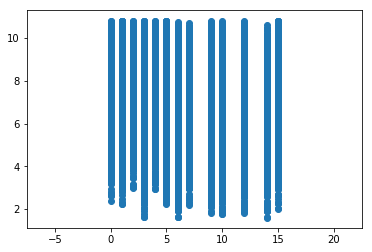

In [38]:
plt.scatter(train["day_count"],train["amount_spent_per_room_night_scaled"])
plt.margins(x=0.5)
plt.show()

In [14]:
#predicting the above columns using random forest classifier
from sklearn.ensemble import RandomForestClassifier
rfmodel=RandomForestClassifier()
rfmodel.fit(newdf_train.iloc[:,0:12],newdf_train['season_holidayed_code'])

/home/oto/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
rfmodel.predict(newdf_test)

array([4., 2., 3., 3., 2., 2., 4., 2., 2., 2., 2., 2., 2., 3., 3., 2., 2.,
       3., 2., 4., 2., 4., 4., 3., 2., 2., 4., 2., 2., 1., 2., 1., 2., 3.,
       2., 3., 3., 2., 2., 4., 4., 4., 3., 3., 1., 3., 2., 4., 3., 1., 2.,
       1., 3., 3., 2., 3., 2., 3., 3., 3., 3., 2., 4., 4., 2., 3., 2., 2.,
       3., 3., 3., 2., 2., 3., 4., 3., 2., 4., 3., 2., 2., 4., 2., 4., 2.,
       2., 2., 2., 1., 1., 3., 2., 2., 2., 2., 3., 3., 2., 2., 2., 2., 3.,
       2., 3., 4., 4., 2., 2., 2., 3., 3., 2., 2., 2., 2., 3., 3., 3., 3.,
       4., 4., 3., 4., 2., 4., 3., 2., 2., 4., 2., 3., 3., 1., 4., 2., 3.,
       2., 2., 3., 2., 2., 3., 2., 4., 2., 1., 2., 3., 1.])

In [16]:
#add the predicted value
total.loc[total.season_holidayed_code.isnull(),'season_holidayed_code']=rfmodel.predict(newdf_test)

In [17]:
#same thing applies for state_code_residence

newdf=total[['persontravellingid','resort_region_code','resort_type_code','room_type_booked_code','roomnights','state_code_resort'
            ,'member_age_buckets','booking_type_code','memberid','cluster_code','reservationstatusid_code','resort_id','state_code_residence']]
newdf_train=newdf[newdf.state_code_residence.notnull()]
newdf_test=newdf[newdf.state_code_residence.isnull()]
newdf_test=newdf_test.drop(columns=['state_code_residence'],axis=1)

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfmodel=RandomForestClassifier()
rfmodel.fit(newdf_train.iloc[:,0:12],newdf_train['state_code_residence'])

/home/oto/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
#adding the predicted value
total.loc[total.state_code_residence.isnull(),'state_code_residence']=rfmodel.predict(newdf_test)

In [20]:
# seperating the train and test data
test=total.iloc[len(train):,:]
train=total.iloc[0:len(train),:]
train['amount_spent_per_room_night_scaled']=train_target  #adding the target variable
train=train[(train.prior_booking_days>=0)&(train.duration_of_stay>=0)]

/home/oto/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
#replacing with mode
test.loc[test.index==41,'prior_booking_days']=14
test.loc[test.index==57,'prior_booking_days']=22
#test[(test.prior_booking_days<0)|(test.duration_of_stay<0)]

/home/oto/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/oto/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
#train=train[(train.season_holidayed_code.notnull())&(train.state_code_residence.notnull())]

In [23]:
#Counter(train.state_code_residence)

In [34]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

In [25]:
#train=train.drop(columns='week',axis=1)

In [26]:
#train=train.drop(columns='day',axis=1)

In [27]:
#train=train.drop(columns='checkout_weekday',axis=1)

In [28]:
#splititng into train and validation date
xtrain,ytrain,xtest,ytest=train_test_split(train.iloc[:,0:29],train['amount_spent_per_room_night_scaled'],test_size=0.25,random_state=123)

In [29]:
train.iloc[:,0:30].head()

,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,...,month,day,week,checkin_weekday,checkout_weekday,prior_booking_days,duration_of_stay,total_people,day_count,amount_spent_per_room_night_scaled
0,3,1,2,0,46,3,3,3,1,2.0,...,4,5,1,3,4,0,1,2,3.0,7.706428
1,1,1,2,0,46,3,3,4,5,2.0,...,4,11,2,5,3,78,5,2,7.0,6.662563
2,1,1,2,0,47,1,5,4,4,2.0,...,2,1,1,6,3,4,4,2,12.0,7.871602
3,1,1,2,2,46,2,2,3,5,2.0,...,6,11,2,3,1,40,5,4,3.0,5.344943
4,1,1,2,0,46,2,2,4,5,2.0,...,12,14,2,0,5,103,5,2,10.0,7.059346


In [42]:
#appling random forest regressor
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
regr.fit(xtrain,xtest)

/home/oto/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
from sklearn.metrics import mean_squared_error
predicted=regr.predict(ytrain)
rms = sqrt(mean_squared_error(ytest, predicted))
print(rms)  #rmse fo random forest

1.066851440948834


In [44]:
from lightgbm import LGBMRegressor
est = LGBMRegressor()
est.fit(xtrain, xtest)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [45]:
predicted=est.predict(ytrain)
rms = sqrt(mean_squared_error(ytest, predicted))
print(rms)  #rmse of light gbm

0.9886809118828382


In [46]:
len(total[total.duration_of_stay>14])

3

In [40]:
from catboost import CatBoostRegressor
model=CatBoostRegressor(iterations=5000)
model.fit(xtrain,xtest) 

0:	learn: 7.5689317	total: 31.9ms	remaining: 2m 39s
1:	learn: 7.3466661	total: 70.1ms	remaining: 2m 55s
2:	learn: 7.1311449	total: 94.3ms	remaining: 2m 37s
3:	learn: 6.9222830	total: 120ms	remaining: 2m 29s
4:	learn: 6.7198524	total: 149ms	remaining: 2m 28s
5:	learn: 6.5236158	total: 174ms	remaining: 2m 24s
6:	learn: 6.3331580	total: 210ms	remaining: 2m 29s
7:	learn: 6.1488746	total: 244ms	remaining: 2m 32s
8:	learn: 5.9702699	total: 280ms	remaining: 2m 35s
9:	learn: 5.7971381	total: 322ms	remaining: 2m 40s
10:	learn: 5.6293538	total: 358ms	remaining: 2m 42s
11:	learn: 5.4666873	total: 379ms	remaining: 2m 37s
12:	learn: 5.3091458	total: 403ms	remaining: 2m 34s
13:	learn: 5.1565987	total: 424ms	remaining: 2m 31s
14:	learn: 5.0087651	total: 453ms	remaining: 2m 30s
15:	learn: 4.8656671	total: 499ms	remaining: 2m 35s
16:	learn: 4.7270431	total: 528ms	remaining: 2m 34s
17:	learn: 4.5927546	total: 559ms	remaining: 2m 34s
18:	learn: 4.4626976	total: 586ms	remaining: 2m 33s
19:	learn: 4.336665

160:	learn: 0.9964002	total: 5.07s	remaining: 2m 32s
161:	learn: 0.9961106	total: 5.1s	remaining: 2m 32s
162:	learn: 0.9958320	total: 5.14s	remaining: 2m 32s
163:	learn: 0.9956131	total: 5.17s	remaining: 2m 32s
164:	learn: 0.9954144	total: 5.2s	remaining: 2m 32s
165:	learn: 0.9951784	total: 5.22s	remaining: 2m 32s
166:	learn: 0.9949681	total: 5.24s	remaining: 2m 31s
167:	learn: 0.9947908	total: 5.26s	remaining: 2m 31s
168:	learn: 0.9944202	total: 5.3s	remaining: 2m 31s
169:	learn: 0.9942101	total: 5.33s	remaining: 2m 31s
170:	learn: 0.9940177	total: 5.35s	remaining: 2m 31s
171:	learn: 0.9938320	total: 5.37s	remaining: 2m 30s
172:	learn: 0.9936473	total: 5.4s	remaining: 2m 30s
173:	learn: 0.9934878	total: 5.42s	remaining: 2m 30s
174:	learn: 0.9933068	total: 5.44s	remaining: 2m 29s
175:	learn: 0.9931284	total: 5.47s	remaining: 2m 30s
176:	learn: 0.9929963	total: 5.5s	remaining: 2m 29s
177:	learn: 0.9928154	total: 5.52s	remaining: 2m 29s
178:	learn: 0.9926418	total: 5.55s	remaining: 2m 29

320:	learn: 0.9825349	total: 9.61s	remaining: 2m 20s
321:	learn: 0.9824777	total: 9.65s	remaining: 2m 20s
322:	learn: 0.9824560	total: 9.69s	remaining: 2m 20s
323:	learn: 0.9824175	total: 9.72s	remaining: 2m 20s
324:	learn: 0.9823708	total: 9.76s	remaining: 2m 20s
325:	learn: 0.9823365	total: 9.8s	remaining: 2m 20s
326:	learn: 0.9822961	total: 9.83s	remaining: 2m 20s
327:	learn: 0.9822511	total: 9.87s	remaining: 2m 20s
328:	learn: 0.9822123	total: 9.91s	remaining: 2m 20s
329:	learn: 0.9821672	total: 9.94s	remaining: 2m 20s
330:	learn: 0.9821013	total: 9.98s	remaining: 2m 20s
331:	learn: 0.9820547	total: 10s	remaining: 2m 20s
332:	learn: 0.9820277	total: 10s	remaining: 2m 20s
333:	learn: 0.9819892	total: 10.1s	remaining: 2m 20s
334:	learn: 0.9819663	total: 10.1s	remaining: 2m 20s
335:	learn: 0.9819392	total: 10.1s	remaining: 2m 20s
336:	learn: 0.9819002	total: 10.1s	remaining: 2m 20s
337:	learn: 0.9818600	total: 10.2s	remaining: 2m 20s
338:	learn: 0.9818422	total: 10.2s	remaining: 2m 20

477:	learn: 0.9779724	total: 14.4s	remaining: 2m 15s
478:	learn: 0.9779495	total: 14.4s	remaining: 2m 15s
479:	learn: 0.9779363	total: 14.4s	remaining: 2m 15s
480:	learn: 0.9779120	total: 14.4s	remaining: 2m 15s
481:	learn: 0.9778990	total: 14.4s	remaining: 2m 15s
482:	learn: 0.9778801	total: 14.5s	remaining: 2m 15s
483:	learn: 0.9778648	total: 14.5s	remaining: 2m 15s
484:	learn: 0.9778506	total: 14.5s	remaining: 2m 15s
485:	learn: 0.9778134	total: 14.5s	remaining: 2m 15s
486:	learn: 0.9777931	total: 14.6s	remaining: 2m 14s
487:	learn: 0.9777770	total: 14.6s	remaining: 2m 14s
488:	learn: 0.9777511	total: 14.6s	remaining: 2m 14s
489:	learn: 0.9777303	total: 14.6s	remaining: 2m 14s
490:	learn: 0.9777239	total: 14.7s	remaining: 2m 14s
491:	learn: 0.9777138	total: 14.7s	remaining: 2m 14s
492:	learn: 0.9776647	total: 14.7s	remaining: 2m 14s
493:	learn: 0.9776432	total: 14.7s	remaining: 2m 14s
494:	learn: 0.9776243	total: 14.8s	remaining: 2m 14s
495:	learn: 0.9776076	total: 14.8s	remaining: 

635:	learn: 0.9750458	total: 19.8s	remaining: 2m 15s
636:	learn: 0.9750352	total: 19.8s	remaining: 2m 15s
637:	learn: 0.9750141	total: 19.8s	remaining: 2m 15s
638:	learn: 0.9749972	total: 19.9s	remaining: 2m 15s
639:	learn: 0.9749883	total: 19.9s	remaining: 2m 15s
640:	learn: 0.9749740	total: 19.9s	remaining: 2m 15s
641:	learn: 0.9749562	total: 20s	remaining: 2m 15s
642:	learn: 0.9749416	total: 20s	remaining: 2m 15s
643:	learn: 0.9749266	total: 20s	remaining: 2m 15s
644:	learn: 0.9749082	total: 20.1s	remaining: 2m 15s
645:	learn: 0.9749006	total: 20.1s	remaining: 2m 15s
646:	learn: 0.9748853	total: 20.1s	remaining: 2m 15s
647:	learn: 0.9748686	total: 20.2s	remaining: 2m 15s
648:	learn: 0.9748567	total: 20.2s	remaining: 2m 15s
649:	learn: 0.9748354	total: 20.3s	remaining: 2m 15s
650:	learn: 0.9748171	total: 20.3s	remaining: 2m 15s
651:	learn: 0.9748086	total: 20.3s	remaining: 2m 15s
652:	learn: 0.9747903	total: 20.4s	remaining: 2m 15s
653:	learn: 0.9747710	total: 20.4s	remaining: 2m 15s

792:	learn: 0.9728770	total: 25.3s	remaining: 2m 14s
793:	learn: 0.9728681	total: 25.3s	remaining: 2m 14s
794:	learn: 0.9728529	total: 25.4s	remaining: 2m 14s
795:	learn: 0.9728400	total: 25.4s	remaining: 2m 14s
796:	learn: 0.9728277	total: 25.4s	remaining: 2m 14s
797:	learn: 0.9728053	total: 25.5s	remaining: 2m 14s
798:	learn: 0.9727921	total: 25.5s	remaining: 2m 14s
799:	learn: 0.9727789	total: 25.5s	remaining: 2m 14s
800:	learn: 0.9727677	total: 25.6s	remaining: 2m 14s
801:	learn: 0.9727496	total: 25.6s	remaining: 2m 14s
802:	learn: 0.9727319	total: 25.6s	remaining: 2m 13s
803:	learn: 0.9727217	total: 25.7s	remaining: 2m 13s
804:	learn: 0.9726991	total: 25.7s	remaining: 2m 14s
805:	learn: 0.9726927	total: 25.7s	remaining: 2m 13s
806:	learn: 0.9726833	total: 25.8s	remaining: 2m 13s
807:	learn: 0.9726430	total: 25.8s	remaining: 2m 13s
808:	learn: 0.9726339	total: 25.9s	remaining: 2m 13s
809:	learn: 0.9726259	total: 25.9s	remaining: 2m 13s
810:	learn: 0.9726150	total: 25.9s	remaining: 

950:	learn: 0.9709250	total: 30.8s	remaining: 2m 11s
951:	learn: 0.9709126	total: 30.8s	remaining: 2m 11s
952:	learn: 0.9708965	total: 30.9s	remaining: 2m 11s
953:	learn: 0.9708786	total: 30.9s	remaining: 2m 11s
954:	learn: 0.9708723	total: 31s	remaining: 2m 11s
955:	learn: 0.9708651	total: 31s	remaining: 2m 11s
956:	learn: 0.9708469	total: 31s	remaining: 2m 11s
957:	learn: 0.9708372	total: 31.1s	remaining: 2m 11s
958:	learn: 0.9708222	total: 31.1s	remaining: 2m 11s
959:	learn: 0.9708113	total: 31.1s	remaining: 2m 11s
960:	learn: 0.9707999	total: 31.2s	remaining: 2m 11s
961:	learn: 0.9707923	total: 31.2s	remaining: 2m 10s
962:	learn: 0.9707780	total: 31.2s	remaining: 2m 10s
963:	learn: 0.9707675	total: 31.3s	remaining: 2m 10s
964:	learn: 0.9707505	total: 31.3s	remaining: 2m 10s
965:	learn: 0.9707409	total: 31.3s	remaining: 2m 10s
966:	learn: 0.9707315	total: 31.4s	remaining: 2m 10s
967:	learn: 0.9707172	total: 31.4s	remaining: 2m 10s
968:	learn: 0.9707073	total: 31.4s	remaining: 2m 10s

1111:	learn: 0.9691824	total: 36.6s	remaining: 2m 8s
1112:	learn: 0.9691681	total: 36.6s	remaining: 2m 7s
1113:	learn: 0.9691550	total: 36.7s	remaining: 2m 7s
1114:	learn: 0.9691480	total: 36.7s	remaining: 2m 7s
1115:	learn: 0.9691350	total: 36.8s	remaining: 2m 7s
1116:	learn: 0.9691305	total: 36.8s	remaining: 2m 7s
1117:	learn: 0.9691226	total: 36.8s	remaining: 2m 7s
1118:	learn: 0.9691117	total: 36.9s	remaining: 2m 7s
1119:	learn: 0.9691028	total: 36.9s	remaining: 2m 7s
1120:	learn: 0.9690948	total: 36.9s	remaining: 2m 7s
1121:	learn: 0.9690849	total: 37s	remaining: 2m 7s
1122:	learn: 0.9690774	total: 37s	remaining: 2m 7s
1123:	learn: 0.9690645	total: 37s	remaining: 2m 7s
1124:	learn: 0.9690554	total: 37.1s	remaining: 2m 7s
1125:	learn: 0.9690423	total: 37.1s	remaining: 2m 7s
1126:	learn: 0.9690322	total: 37.1s	remaining: 2m 7s
1127:	learn: 0.9690204	total: 37.2s	remaining: 2m 7s
1128:	learn: 0.9690094	total: 37.2s	remaining: 2m 7s
1129:	learn: 0.9690065	total: 37.2s	remaining: 2m 7s

1267:	learn: 0.9677045	total: 43.9s	remaining: 2m 9s
1268:	learn: 0.9676943	total: 44s	remaining: 2m 9s
1269:	learn: 0.9676833	total: 44s	remaining: 2m 9s
1270:	learn: 0.9676688	total: 44.1s	remaining: 2m 9s
1271:	learn: 0.9676644	total: 44.1s	remaining: 2m 9s
1272:	learn: 0.9676531	total: 44.2s	remaining: 2m 9s
1273:	learn: 0.9676435	total: 44.3s	remaining: 2m 9s
1274:	learn: 0.9676407	total: 44.4s	remaining: 2m 9s
1275:	learn: 0.9676229	total: 44.5s	remaining: 2m 9s
1276:	learn: 0.9676103	total: 44.6s	remaining: 2m 9s
1277:	learn: 0.9676030	total: 44.7s	remaining: 2m 10s
1278:	learn: 0.9675966	total: 44.8s	remaining: 2m 10s
1279:	learn: 0.9675804	total: 45s	remaining: 2m 10s
1280:	learn: 0.9675713	total: 45s	remaining: 2m 10s
1281:	learn: 0.9675570	total: 45.1s	remaining: 2m 10s
1282:	learn: 0.9675479	total: 45.3s	remaining: 2m 11s
1283:	learn: 0.9675341	total: 45.3s	remaining: 2m 11s
1284:	learn: 0.9675210	total: 45.4s	remaining: 2m 11s
1285:	learn: 0.9675130	total: 45.5s	remaining:

1422:	learn: 0.9663400	total: 53.2s	remaining: 2m 13s
1423:	learn: 0.9663298	total: 53.3s	remaining: 2m 13s
1424:	learn: 0.9663211	total: 53.3s	remaining: 2m 13s
1425:	learn: 0.9663135	total: 53.4s	remaining: 2m 13s
1426:	learn: 0.9663093	total: 53.5s	remaining: 2m 13s
1427:	learn: 0.9662998	total: 53.5s	remaining: 2m 13s
1428:	learn: 0.9662879	total: 53.5s	remaining: 2m 13s
1429:	learn: 0.9662817	total: 53.6s	remaining: 2m 13s
1430:	learn: 0.9662711	total: 53.6s	remaining: 2m 13s
1431:	learn: 0.9662563	total: 53.7s	remaining: 2m 13s
1432:	learn: 0.9662426	total: 53.7s	remaining: 2m 13s
1433:	learn: 0.9662362	total: 53.7s	remaining: 2m 13s
1434:	learn: 0.9662234	total: 53.8s	remaining: 2m 13s
1435:	learn: 0.9662125	total: 53.9s	remaining: 2m 13s
1436:	learn: 0.9662089	total: 54s	remaining: 2m 13s
1437:	learn: 0.9662029	total: 54s	remaining: 2m 13s
1438:	learn: 0.9661996	total: 54s	remaining: 2m 13s
1439:	learn: 0.9661883	total: 54.1s	remaining: 2m 13s
1440:	learn: 0.9661790	total: 54.1

1580:	learn: 0.9649789	total: 1m	remaining: 2m 10s
1581:	learn: 0.9649755	total: 1m	remaining: 2m 10s
1582:	learn: 0.9649697	total: 1m	remaining: 2m 10s
1583:	learn: 0.9649576	total: 1m	remaining: 2m 10s
1584:	learn: 0.9649509	total: 1m	remaining: 2m 10s
1585:	learn: 0.9649467	total: 1m	remaining: 2m 10s
1586:	learn: 0.9649354	total: 1m	remaining: 2m 10s
1587:	learn: 0.9649276	total: 1m	remaining: 2m 10s
1588:	learn: 0.9649211	total: 1m	remaining: 2m 9s
1589:	learn: 0.9649117	total: 1m	remaining: 2m 9s
1590:	learn: 0.9648990	total: 1m	remaining: 2m 9s
1591:	learn: 0.9648918	total: 1m	remaining: 2m 9s
1592:	learn: 0.9648809	total: 1m	remaining: 2m 9s
1593:	learn: 0.9648692	total: 1m	remaining: 2m 9s
1594:	learn: 0.9648636	total: 1m	remaining: 2m 9s
1595:	learn: 0.9648574	total: 1m	remaining: 2m 9s
1596:	learn: 0.9648494	total: 1m	remaining: 2m 9s
1597:	learn: 0.9648441	total: 1m	remaining: 2m 9s
1598:	learn: 0.9648337	total: 1m	remaining: 2m 9s
1599:	learn: 0.9648265	total: 1m	remaining

1736:	learn: 0.9636554	total: 1m 5s	remaining: 2m 3s
1737:	learn: 0.9636487	total: 1m 5s	remaining: 2m 3s
1738:	learn: 0.9636417	total: 1m 5s	remaining: 2m 3s
1739:	learn: 0.9636346	total: 1m 5s	remaining: 2m 3s
1740:	learn: 0.9636316	total: 1m 6s	remaining: 2m 3s
1741:	learn: 0.9636197	total: 1m 6s	remaining: 2m 3s
1742:	learn: 0.9636133	total: 1m 6s	remaining: 2m 3s
1743:	learn: 0.9636021	total: 1m 6s	remaining: 2m 3s
1744:	learn: 0.9635948	total: 1m 6s	remaining: 2m 3s
1745:	learn: 0.9635858	total: 1m 6s	remaining: 2m 3s
1746:	learn: 0.9635816	total: 1m 6s	remaining: 2m 3s
1747:	learn: 0.9635716	total: 1m 6s	remaining: 2m 3s
1748:	learn: 0.9635610	total: 1m 6s	remaining: 2m 3s
1749:	learn: 0.9635493	total: 1m 6s	remaining: 2m 3s
1750:	learn: 0.9635446	total: 1m 6s	remaining: 2m 3s
1751:	learn: 0.9635417	total: 1m 6s	remaining: 2m 3s
1752:	learn: 0.9635361	total: 1m 6s	remaining: 2m 3s
1753:	learn: 0.9635281	total: 1m 6s	remaining: 2m 3s
1754:	learn: 0.9635208	total: 1m 6s	remaining:

1891:	learn: 0.9625010	total: 1m 11s	remaining: 1m 57s
1892:	learn: 0.9624918	total: 1m 11s	remaining: 1m 57s
1893:	learn: 0.9624824	total: 1m 11s	remaining: 1m 57s
1894:	learn: 0.9624704	total: 1m 11s	remaining: 1m 57s
1895:	learn: 0.9624630	total: 1m 11s	remaining: 1m 57s
1896:	learn: 0.9624538	total: 1m 11s	remaining: 1m 57s
1897:	learn: 0.9624458	total: 1m 11s	remaining: 1m 57s
1898:	learn: 0.9624362	total: 1m 11s	remaining: 1m 57s
1899:	learn: 0.9624281	total: 1m 11s	remaining: 1m 57s
1900:	learn: 0.9624190	total: 1m 11s	remaining: 1m 57s
1901:	learn: 0.9624093	total: 1m 11s	remaining: 1m 57s
1902:	learn: 0.9624031	total: 1m 11s	remaining: 1m 57s
1903:	learn: 0.9623997	total: 1m 11s	remaining: 1m 56s
1904:	learn: 0.9623937	total: 1m 11s	remaining: 1m 56s
1905:	learn: 0.9623846	total: 1m 12s	remaining: 1m 56s
1906:	learn: 0.9623802	total: 1m 12s	remaining: 1m 56s
1907:	learn: 0.9623743	total: 1m 12s	remaining: 1m 56s
1908:	learn: 0.9623637	total: 1m 12s	remaining: 1m 56s
1909:	lear

2041:	learn: 0.9614046	total: 1m 16s	remaining: 1m 51s
2042:	learn: 0.9613981	total: 1m 16s	remaining: 1m 51s
2043:	learn: 0.9613860	total: 1m 16s	remaining: 1m 51s
2044:	learn: 0.9613826	total: 1m 17s	remaining: 1m 51s
2045:	learn: 0.9613709	total: 1m 17s	remaining: 1m 51s
2046:	learn: 0.9613627	total: 1m 17s	remaining: 1m 51s
2047:	learn: 0.9613598	total: 1m 17s	remaining: 1m 51s
2048:	learn: 0.9613563	total: 1m 17s	remaining: 1m 51s
2049:	learn: 0.9613491	total: 1m 17s	remaining: 1m 51s
2050:	learn: 0.9613449	total: 1m 17s	remaining: 1m 51s
2051:	learn: 0.9613416	total: 1m 17s	remaining: 1m 51s
2052:	learn: 0.9613314	total: 1m 17s	remaining: 1m 50s
2053:	learn: 0.9613230	total: 1m 17s	remaining: 1m 50s
2054:	learn: 0.9613154	total: 1m 17s	remaining: 1m 50s
2055:	learn: 0.9613066	total: 1m 17s	remaining: 1m 50s
2056:	learn: 0.9613008	total: 1m 17s	remaining: 1m 50s
2057:	learn: 0.9612949	total: 1m 17s	remaining: 1m 50s
2058:	learn: 0.9612931	total: 1m 17s	remaining: 1m 50s
2059:	lear

2191:	learn: 0.9603347	total: 1m 22s	remaining: 1m 45s
2192:	learn: 0.9603264	total: 1m 22s	remaining: 1m 45s
2193:	learn: 0.9603212	total: 1m 22s	remaining: 1m 45s
2194:	learn: 0.9603179	total: 1m 22s	remaining: 1m 45s
2195:	learn: 0.9603129	total: 1m 22s	remaining: 1m 45s
2196:	learn: 0.9603031	total: 1m 22s	remaining: 1m 45s
2197:	learn: 0.9602991	total: 1m 22s	remaining: 1m 45s
2198:	learn: 0.9602931	total: 1m 22s	remaining: 1m 45s
2199:	learn: 0.9602805	total: 1m 22s	remaining: 1m 45s
2200:	learn: 0.9602785	total: 1m 22s	remaining: 1m 45s
2201:	learn: 0.9602745	total: 1m 22s	remaining: 1m 45s
2202:	learn: 0.9602634	total: 1m 22s	remaining: 1m 45s
2203:	learn: 0.9602559	total: 1m 22s	remaining: 1m 45s
2204:	learn: 0.9602473	total: 1m 22s	remaining: 1m 45s
2205:	learn: 0.9602389	total: 1m 23s	remaining: 1m 45s
2206:	learn: 0.9602364	total: 1m 23s	remaining: 1m 45s
2207:	learn: 0.9602246	total: 1m 23s	remaining: 1m 45s
2208:	learn: 0.9602111	total: 1m 23s	remaining: 1m 45s
2209:	lear

2344:	learn: 0.9592651	total: 1m 29s	remaining: 1m 40s
2345:	learn: 0.9592561	total: 1m 29s	remaining: 1m 40s
2346:	learn: 0.9592517	total: 1m 29s	remaining: 1m 40s
2347:	learn: 0.9592460	total: 1m 29s	remaining: 1m 40s
2348:	learn: 0.9592377	total: 1m 29s	remaining: 1m 40s
2349:	learn: 0.9592279	total: 1m 29s	remaining: 1m 40s
2350:	learn: 0.9592181	total: 1m 29s	remaining: 1m 40s
2351:	learn: 0.9592113	total: 1m 29s	remaining: 1m 40s
2352:	learn: 0.9592063	total: 1m 29s	remaining: 1m 40s
2353:	learn: 0.9591966	total: 1m 29s	remaining: 1m 40s
2354:	learn: 0.9591870	total: 1m 29s	remaining: 1m 40s
2355:	learn: 0.9591784	total: 1m 29s	remaining: 1m 40s
2356:	learn: 0.9591755	total: 1m 29s	remaining: 1m 40s
2357:	learn: 0.9591660	total: 1m 29s	remaining: 1m 40s
2358:	learn: 0.9591557	total: 1m 29s	remaining: 1m 40s
2359:	learn: 0.9591512	total: 1m 29s	remaining: 1m 40s
2360:	learn: 0.9591441	total: 1m 29s	remaining: 1m 40s
2361:	learn: 0.9591400	total: 1m 29s	remaining: 1m 40s
2362:	lear

2498:	learn: 0.9581554	total: 1m 34s	remaining: 1m 34s
2499:	learn: 0.9581519	total: 1m 34s	remaining: 1m 34s
2500:	learn: 0.9581450	total: 1m 34s	remaining: 1m 34s
2501:	learn: 0.9581403	total: 1m 34s	remaining: 1m 34s
2502:	learn: 0.9581343	total: 1m 34s	remaining: 1m 34s
2503:	learn: 0.9581251	total: 1m 34s	remaining: 1m 34s
2504:	learn: 0.9581196	total: 1m 34s	remaining: 1m 34s
2505:	learn: 0.9581132	total: 1m 34s	remaining: 1m 34s
2506:	learn: 0.9581082	total: 1m 34s	remaining: 1m 34s
2507:	learn: 0.9581000	total: 1m 35s	remaining: 1m 34s
2508:	learn: 0.9580922	total: 1m 35s	remaining: 1m 34s
2509:	learn: 0.9580831	total: 1m 35s	remaining: 1m 34s
2510:	learn: 0.9580756	total: 1m 35s	remaining: 1m 34s
2511:	learn: 0.9580671	total: 1m 35s	remaining: 1m 34s
2512:	learn: 0.9580598	total: 1m 35s	remaining: 1m 34s
2513:	learn: 0.9580482	total: 1m 35s	remaining: 1m 34s
2514:	learn: 0.9580415	total: 1m 35s	remaining: 1m 34s
2515:	learn: 0.9580337	total: 1m 35s	remaining: 1m 34s
2516:	lear

2648:	learn: 0.9571213	total: 1m 40s	remaining: 1m 28s
2649:	learn: 0.9571145	total: 1m 40s	remaining: 1m 28s
2650:	learn: 0.9571068	total: 1m 40s	remaining: 1m 28s
2651:	learn: 0.9571033	total: 1m 40s	remaining: 1m 28s
2652:	learn: 0.9571002	total: 1m 40s	remaining: 1m 28s
2653:	learn: 0.9570940	total: 1m 40s	remaining: 1m 28s
2654:	learn: 0.9570873	total: 1m 40s	remaining: 1m 28s
2655:	learn: 0.9570821	total: 1m 40s	remaining: 1m 28s
2656:	learn: 0.9570755	total: 1m 40s	remaining: 1m 28s
2657:	learn: 0.9570664	total: 1m 40s	remaining: 1m 28s
2658:	learn: 0.9570562	total: 1m 40s	remaining: 1m 28s
2659:	learn: 0.9570508	total: 1m 40s	remaining: 1m 28s
2660:	learn: 0.9570455	total: 1m 40s	remaining: 1m 28s
2661:	learn: 0.9570431	total: 1m 40s	remaining: 1m 28s
2662:	learn: 0.9570365	total: 1m 40s	remaining: 1m 28s
2663:	learn: 0.9570332	total: 1m 40s	remaining: 1m 28s
2664:	learn: 0.9570268	total: 1m 40s	remaining: 1m 28s
2665:	learn: 0.9570160	total: 1m 40s	remaining: 1m 28s
2666:	lear

2798:	learn: 0.9561295	total: 1m 45s	remaining: 1m 22s
2799:	learn: 0.9561241	total: 1m 45s	remaining: 1m 22s
2800:	learn: 0.9561186	total: 1m 45s	remaining: 1m 22s
2801:	learn: 0.9561122	total: 1m 45s	remaining: 1m 22s
2802:	learn: 0.9561050	total: 1m 45s	remaining: 1m 22s
2803:	learn: 0.9560942	total: 1m 45s	remaining: 1m 22s
2804:	learn: 0.9560890	total: 1m 45s	remaining: 1m 22s
2805:	learn: 0.9560870	total: 1m 45s	remaining: 1m 22s
2806:	learn: 0.9560767	total: 1m 45s	remaining: 1m 22s
2807:	learn: 0.9560709	total: 1m 45s	remaining: 1m 22s
2808:	learn: 0.9560602	total: 1m 45s	remaining: 1m 22s
2809:	learn: 0.9560551	total: 1m 45s	remaining: 1m 22s
2810:	learn: 0.9560431	total: 1m 45s	remaining: 1m 22s
2811:	learn: 0.9560335	total: 1m 45s	remaining: 1m 22s
2812:	learn: 0.9560254	total: 1m 45s	remaining: 1m 22s
2813:	learn: 0.9560207	total: 1m 46s	remaining: 1m 22s
2814:	learn: 0.9560167	total: 1m 46s	remaining: 1m 22s
2815:	learn: 0.9560126	total: 1m 46s	remaining: 1m 22s
2816:	lear

2948:	learn: 0.9551455	total: 1m 50s	remaining: 1m 17s
2949:	learn: 0.9551426	total: 1m 50s	remaining: 1m 17s
2950:	learn: 0.9551379	total: 1m 50s	remaining: 1m 17s
2951:	learn: 0.9551300	total: 1m 50s	remaining: 1m 16s
2952:	learn: 0.9551241	total: 1m 51s	remaining: 1m 16s
2953:	learn: 0.9551203	total: 1m 51s	remaining: 1m 16s
2954:	learn: 0.9551150	total: 1m 51s	remaining: 1m 16s
2955:	learn: 0.9551040	total: 1m 51s	remaining: 1m 16s
2956:	learn: 0.9551012	total: 1m 51s	remaining: 1m 16s
2957:	learn: 0.9550955	total: 1m 51s	remaining: 1m 16s
2958:	learn: 0.9550887	total: 1m 51s	remaining: 1m 16s
2959:	learn: 0.9550853	total: 1m 51s	remaining: 1m 16s
2960:	learn: 0.9550814	total: 1m 51s	remaining: 1m 16s
2961:	learn: 0.9550759	total: 1m 51s	remaining: 1m 16s
2962:	learn: 0.9550727	total: 1m 51s	remaining: 1m 16s
2963:	learn: 0.9550666	total: 1m 51s	remaining: 1m 16s
2964:	learn: 0.9550615	total: 1m 51s	remaining: 1m 16s
2965:	learn: 0.9550512	total: 1m 51s	remaining: 1m 16s
2966:	lear

3097:	learn: 0.9542138	total: 1m 56s	remaining: 1m 11s
3098:	learn: 0.9542062	total: 1m 56s	remaining: 1m 11s
3099:	learn: 0.9542007	total: 1m 56s	remaining: 1m 11s
3100:	learn: 0.9541946	total: 1m 56s	remaining: 1m 11s
3101:	learn: 0.9541897	total: 1m 56s	remaining: 1m 11s
3102:	learn: 0.9541835	total: 1m 56s	remaining: 1m 11s
3103:	learn: 0.9541795	total: 1m 56s	remaining: 1m 11s
3104:	learn: 0.9541649	total: 1m 56s	remaining: 1m 11s
3105:	learn: 0.9541600	total: 1m 56s	remaining: 1m 11s
3106:	learn: 0.9541557	total: 1m 56s	remaining: 1m 11s
3107:	learn: 0.9541473	total: 1m 56s	remaining: 1m 11s
3108:	learn: 0.9541418	total: 1m 57s	remaining: 1m 11s
3109:	learn: 0.9541340	total: 1m 57s	remaining: 1m 11s
3110:	learn: 0.9541319	total: 1m 57s	remaining: 1m 11s
3111:	learn: 0.9541259	total: 1m 57s	remaining: 1m 11s
3112:	learn: 0.9541216	total: 1m 57s	remaining: 1m 11s
3113:	learn: 0.9541189	total: 1m 57s	remaining: 1m 10s
3114:	learn: 0.9541088	total: 1m 57s	remaining: 1m 10s
3115:	lear

3253:	learn: 0.9532117	total: 2m 2s	remaining: 1m 5s
3254:	learn: 0.9532054	total: 2m 2s	remaining: 1m 5s
3255:	learn: 0.9531976	total: 2m 2s	remaining: 1m 5s
3256:	learn: 0.9531904	total: 2m 2s	remaining: 1m 5s
3257:	learn: 0.9531797	total: 2m 2s	remaining: 1m 5s
3258:	learn: 0.9531681	total: 2m 2s	remaining: 1m 5s
3259:	learn: 0.9531629	total: 2m 2s	remaining: 1m 5s
3260:	learn: 0.9531548	total: 2m 2s	remaining: 1m 5s
3261:	learn: 0.9531445	total: 2m 2s	remaining: 1m 5s
3262:	learn: 0.9531394	total: 2m 2s	remaining: 1m 5s
3263:	learn: 0.9531330	total: 2m 2s	remaining: 1m 5s
3264:	learn: 0.9531293	total: 2m 2s	remaining: 1m 5s
3265:	learn: 0.9531225	total: 2m 2s	remaining: 1m 5s
3266:	learn: 0.9531189	total: 2m 2s	remaining: 1m 5s
3267:	learn: 0.9531081	total: 2m 2s	remaining: 1m 5s
3268:	learn: 0.9531019	total: 2m 2s	remaining: 1m 5s
3269:	learn: 0.9530952	total: 2m 2s	remaining: 1m 5s
3270:	learn: 0.9530847	total: 2m 2s	remaining: 1m 4s
3271:	learn: 0.9530765	total: 2m 2s	remaining:

3414:	learn: 0.9521959	total: 2m 8s	remaining: 59.5s
3415:	learn: 0.9521934	total: 2m 8s	remaining: 59.4s
3416:	learn: 0.9521858	total: 2m 8s	remaining: 59.4s
3417:	learn: 0.9521792	total: 2m 8s	remaining: 59.4s
3418:	learn: 0.9521745	total: 2m 8s	remaining: 59.3s
3419:	learn: 0.9521701	total: 2m 8s	remaining: 59.3s
3420:	learn: 0.9521626	total: 2m 8s	remaining: 59.2s
3421:	learn: 0.9521601	total: 2m 8s	remaining: 59.2s
3422:	learn: 0.9521533	total: 2m 8s	remaining: 59.2s
3423:	learn: 0.9521431	total: 2m 8s	remaining: 59.1s
3424:	learn: 0.9521395	total: 2m 8s	remaining: 59.1s
3425:	learn: 0.9521334	total: 2m 8s	remaining: 59.1s
3426:	learn: 0.9521277	total: 2m 8s	remaining: 59s
3427:	learn: 0.9521193	total: 2m 8s	remaining: 59s
3428:	learn: 0.9521143	total: 2m 8s	remaining: 58.9s
3429:	learn: 0.9521067	total: 2m 8s	remaining: 58.9s
3430:	learn: 0.9521035	total: 2m 8s	remaining: 58.9s
3431:	learn: 0.9520973	total: 2m 8s	remaining: 58.8s
3432:	learn: 0.9520914	total: 2m 8s	remaining: 58.

3569:	learn: 0.9512488	total: 2m 13s	remaining: 53.6s
3570:	learn: 0.9512438	total: 2m 13s	remaining: 53.5s
3571:	learn: 0.9512355	total: 2m 13s	remaining: 53.5s
3572:	learn: 0.9512264	total: 2m 13s	remaining: 53.5s
3573:	learn: 0.9512232	total: 2m 13s	remaining: 53.4s
3574:	learn: 0.9512146	total: 2m 13s	remaining: 53.4s
3575:	learn: 0.9512073	total: 2m 13s	remaining: 53.3s
3576:	learn: 0.9512010	total: 2m 14s	remaining: 53.3s
3577:	learn: 0.9511947	total: 2m 14s	remaining: 53.3s
3578:	learn: 0.9511890	total: 2m 14s	remaining: 53.2s
3579:	learn: 0.9511799	total: 2m 14s	remaining: 53.2s
3580:	learn: 0.9511739	total: 2m 14s	remaining: 53.2s
3581:	learn: 0.9511721	total: 2m 14s	remaining: 53.1s
3582:	learn: 0.9511687	total: 2m 14s	remaining: 53.1s
3583:	learn: 0.9511581	total: 2m 14s	remaining: 53s
3584:	learn: 0.9511529	total: 2m 14s	remaining: 53s
3585:	learn: 0.9511482	total: 2m 14s	remaining: 53s
3586:	learn: 0.9511400	total: 2m 14s	remaining: 52.9s
3587:	learn: 0.9511314	total: 2m 1

3725:	learn: 0.9502793	total: 2m 19s	remaining: 47.7s
3726:	learn: 0.9502777	total: 2m 19s	remaining: 47.6s
3727:	learn: 0.9502730	total: 2m 19s	remaining: 47.6s
3728:	learn: 0.9502650	total: 2m 19s	remaining: 47.6s
3729:	learn: 0.9502590	total: 2m 19s	remaining: 47.5s
3730:	learn: 0.9502515	total: 2m 19s	remaining: 47.5s
3731:	learn: 0.9502463	total: 2m 19s	remaining: 47.4s
3732:	learn: 0.9502398	total: 2m 19s	remaining: 47.4s
3733:	learn: 0.9502330	total: 2m 19s	remaining: 47.4s
3734:	learn: 0.9502299	total: 2m 19s	remaining: 47.3s
3735:	learn: 0.9502208	total: 2m 19s	remaining: 47.3s
3736:	learn: 0.9502085	total: 2m 19s	remaining: 47.3s
3737:	learn: 0.9502005	total: 2m 19s	remaining: 47.2s
3738:	learn: 0.9501956	total: 2m 19s	remaining: 47.2s
3739:	learn: 0.9501885	total: 2m 19s	remaining: 47.1s
3740:	learn: 0.9501847	total: 2m 19s	remaining: 47.1s
3741:	learn: 0.9501804	total: 2m 19s	remaining: 47.1s
3742:	learn: 0.9501737	total: 2m 20s	remaining: 47s
3743:	learn: 0.9501656	total: 

3879:	learn: 0.9493407	total: 2m 24s	remaining: 41.8s
3880:	learn: 0.9493376	total: 2m 24s	remaining: 41.8s
3881:	learn: 0.9493315	total: 2m 25s	remaining: 41.8s
3882:	learn: 0.9493291	total: 2m 25s	remaining: 41.7s
3883:	learn: 0.9493220	total: 2m 25s	remaining: 41.7s
3884:	learn: 0.9493177	total: 2m 25s	remaining: 41.6s
3885:	learn: 0.9493149	total: 2m 25s	remaining: 41.6s
3886:	learn: 0.9493073	total: 2m 25s	remaining: 41.6s
3887:	learn: 0.9493008	total: 2m 25s	remaining: 41.5s
3888:	learn: 0.9492967	total: 2m 25s	remaining: 41.5s
3889:	learn: 0.9492883	total: 2m 25s	remaining: 41.5s
3890:	learn: 0.9492793	total: 2m 25s	remaining: 41.4s
3891:	learn: 0.9492747	total: 2m 25s	remaining: 41.4s
3892:	learn: 0.9492669	total: 2m 25s	remaining: 41.4s
3893:	learn: 0.9492600	total: 2m 25s	remaining: 41.3s
3894:	learn: 0.9492554	total: 2m 25s	remaining: 41.3s
3895:	learn: 0.9492506	total: 2m 25s	remaining: 41.2s
3896:	learn: 0.9492432	total: 2m 25s	remaining: 41.2s
3897:	learn: 0.9492388	total

4033:	learn: 0.9483854	total: 2m 31s	remaining: 36.2s
4034:	learn: 0.9483776	total: 2m 31s	remaining: 36.2s
4035:	learn: 0.9483693	total: 2m 31s	remaining: 36.2s
4036:	learn: 0.9483568	total: 2m 31s	remaining: 36.1s
4037:	learn: 0.9483490	total: 2m 31s	remaining: 36.1s
4038:	learn: 0.9483436	total: 2m 31s	remaining: 36.1s
4039:	learn: 0.9483405	total: 2m 31s	remaining: 36s
4040:	learn: 0.9483369	total: 2m 31s	remaining: 36s
4041:	learn: 0.9483314	total: 2m 31s	remaining: 36s
4042:	learn: 0.9483221	total: 2m 31s	remaining: 35.9s
4043:	learn: 0.9483174	total: 2m 31s	remaining: 35.9s
4044:	learn: 0.9483149	total: 2m 31s	remaining: 35.9s
4045:	learn: 0.9483058	total: 2m 31s	remaining: 35.8s
4046:	learn: 0.9483030	total: 2m 32s	remaining: 35.8s
4047:	learn: 0.9482984	total: 2m 32s	remaining: 35.8s
4048:	learn: 0.9482930	total: 2m 32s	remaining: 35.7s
4049:	learn: 0.9482876	total: 2m 32s	remaining: 35.7s
4050:	learn: 0.9482785	total: 2m 32s	remaining: 35.6s
4051:	learn: 0.9482699	total: 2m 3

4190:	learn: 0.9474390	total: 2m 38s	remaining: 30.5s
4191:	learn: 0.9474310	total: 2m 38s	remaining: 30.5s
4192:	learn: 0.9474271	total: 2m 38s	remaining: 30.4s
4193:	learn: 0.9474247	total: 2m 38s	remaining: 30.4s
4194:	learn: 0.9474180	total: 2m 38s	remaining: 30.4s
4195:	learn: 0.9474160	total: 2m 38s	remaining: 30.3s
4196:	learn: 0.9474124	total: 2m 38s	remaining: 30.3s
4197:	learn: 0.9474055	total: 2m 38s	remaining: 30.3s
4198:	learn: 0.9473958	total: 2m 38s	remaining: 30.2s
4199:	learn: 0.9473919	total: 2m 38s	remaining: 30.2s
4200:	learn: 0.9473864	total: 2m 38s	remaining: 30.1s
4201:	learn: 0.9473821	total: 2m 38s	remaining: 30.1s
4202:	learn: 0.9473752	total: 2m 38s	remaining: 30.1s
4203:	learn: 0.9473678	total: 2m 38s	remaining: 30s
4204:	learn: 0.9473601	total: 2m 38s	remaining: 30s
4205:	learn: 0.9473546	total: 2m 38s	remaining: 29.9s
4206:	learn: 0.9473507	total: 2m 38s	remaining: 29.9s
4207:	learn: 0.9473439	total: 2m 38s	remaining: 29.9s
4208:	learn: 0.9473378	total: 2m

4345:	learn: 0.9465670	total: 2m 44s	remaining: 24.7s
4346:	learn: 0.9465629	total: 2m 44s	remaining: 24.7s
4347:	learn: 0.9465598	total: 2m 44s	remaining: 24.6s
4348:	learn: 0.9465577	total: 2m 44s	remaining: 24.6s
4349:	learn: 0.9465515	total: 2m 44s	remaining: 24.6s
4350:	learn: 0.9465450	total: 2m 44s	remaining: 24.5s
4351:	learn: 0.9465374	total: 2m 44s	remaining: 24.5s
4352:	learn: 0.9465292	total: 2m 44s	remaining: 24.5s
4353:	learn: 0.9465237	total: 2m 44s	remaining: 24.4s
4354:	learn: 0.9465165	total: 2m 44s	remaining: 24.4s
4355:	learn: 0.9465114	total: 2m 44s	remaining: 24.3s
4356:	learn: 0.9465055	total: 2m 44s	remaining: 24.3s
4357:	learn: 0.9465029	total: 2m 44s	remaining: 24.3s
4358:	learn: 0.9464994	total: 2m 44s	remaining: 24.2s
4359:	learn: 0.9464914	total: 2m 44s	remaining: 24.2s
4360:	learn: 0.9464865	total: 2m 44s	remaining: 24.2s
4361:	learn: 0.9464822	total: 2m 44s	remaining: 24.1s
4362:	learn: 0.9464725	total: 2m 45s	remaining: 24.1s
4363:	learn: 0.9464675	total

4499:	learn: 0.9456676	total: 2m 50s	remaining: 18.9s
4500:	learn: 0.9456618	total: 2m 50s	remaining: 18.9s
4501:	learn: 0.9456534	total: 2m 50s	remaining: 18.9s
4502:	learn: 0.9456464	total: 2m 50s	remaining: 18.8s
4503:	learn: 0.9456413	total: 2m 50s	remaining: 18.8s
4504:	learn: 0.9456378	total: 2m 50s	remaining: 18.8s
4505:	learn: 0.9456321	total: 2m 50s	remaining: 18.7s
4506:	learn: 0.9456301	total: 2m 50s	remaining: 18.7s
4507:	learn: 0.9456247	total: 2m 50s	remaining: 18.7s
4508:	learn: 0.9456183	total: 2m 51s	remaining: 18.6s
4509:	learn: 0.9456131	total: 2m 51s	remaining: 18.6s
4510:	learn: 0.9456062	total: 2m 51s	remaining: 18.5s
4511:	learn: 0.9456007	total: 2m 51s	remaining: 18.5s
4512:	learn: 0.9455918	total: 2m 51s	remaining: 18.5s
4513:	learn: 0.9455858	total: 2m 51s	remaining: 18.4s
4514:	learn: 0.9455777	total: 2m 51s	remaining: 18.4s
4515:	learn: 0.9455710	total: 2m 51s	remaining: 18.4s
4516:	learn: 0.9455649	total: 2m 51s	remaining: 18.3s
4517:	learn: 0.9455580	total

4652:	learn: 0.9447722	total: 2m 56s	remaining: 13.2s
4653:	learn: 0.9447706	total: 2m 56s	remaining: 13.1s
4654:	learn: 0.9447670	total: 2m 56s	remaining: 13.1s
4655:	learn: 0.9447634	total: 2m 56s	remaining: 13.1s
4656:	learn: 0.9447597	total: 2m 56s	remaining: 13s
4657:	learn: 0.9447526	total: 2m 56s	remaining: 13s
4658:	learn: 0.9447462	total: 2m 56s	remaining: 13s
4659:	learn: 0.9447403	total: 2m 57s	remaining: 12.9s
4660:	learn: 0.9447368	total: 2m 57s	remaining: 12.9s
4661:	learn: 0.9447327	total: 2m 57s	remaining: 12.8s
4662:	learn: 0.9447278	total: 2m 57s	remaining: 12.8s
4663:	learn: 0.9447234	total: 2m 57s	remaining: 12.8s
4664:	learn: 0.9447199	total: 2m 57s	remaining: 12.7s
4665:	learn: 0.9447132	total: 2m 57s	remaining: 12.7s
4666:	learn: 0.9447036	total: 2m 57s	remaining: 12.7s
4667:	learn: 0.9446951	total: 2m 57s	remaining: 12.6s
4668:	learn: 0.9446904	total: 2m 57s	remaining: 12.6s
4669:	learn: 0.9446848	total: 2m 57s	remaining: 12.5s
4670:	learn: 0.9446831	total: 2m 5

4810:	learn: 0.9439191	total: 3m 2s	remaining: 7.17s
4811:	learn: 0.9439160	total: 3m 2s	remaining: 7.14s
4812:	learn: 0.9439105	total: 3m 2s	remaining: 7.1s
4813:	learn: 0.9439058	total: 3m 2s	remaining: 7.06s
4814:	learn: 0.9439000	total: 3m 2s	remaining: 7.02s
4815:	learn: 0.9438943	total: 3m 2s	remaining: 6.98s
4816:	learn: 0.9438927	total: 3m 2s	remaining: 6.95s
4817:	learn: 0.9438891	total: 3m 2s	remaining: 6.91s
4818:	learn: 0.9438817	total: 3m 2s	remaining: 6.87s
4819:	learn: 0.9438755	total: 3m 2s	remaining: 6.83s
4820:	learn: 0.9438665	total: 3m 2s	remaining: 6.79s
4821:	learn: 0.9438579	total: 3m 3s	remaining: 6.76s
4822:	learn: 0.9438467	total: 3m 3s	remaining: 6.72s
4823:	learn: 0.9438388	total: 3m 3s	remaining: 6.68s
4824:	learn: 0.9438324	total: 3m 3s	remaining: 6.64s
4825:	learn: 0.9438250	total: 3m 3s	remaining: 6.6s
4826:	learn: 0.9438157	total: 3m 3s	remaining: 6.57s
4827:	learn: 0.9438064	total: 3m 3s	remaining: 6.53s
4828:	learn: 0.9437994	total: 3m 3s	remaining: 6

4965:	learn: 0.9430628	total: 3m 8s	remaining: 1.29s
4966:	learn: 0.9430611	total: 3m 8s	remaining: 1.25s
4967:	learn: 0.9430522	total: 3m 8s	remaining: 1.22s
4968:	learn: 0.9430450	total: 3m 8s	remaining: 1.18s
4969:	learn: 0.9430363	total: 3m 8s	remaining: 1.14s
4970:	learn: 0.9430317	total: 3m 8s	remaining: 1.1s
4971:	learn: 0.9430277	total: 3m 8s	remaining: 1.06s
4972:	learn: 0.9430222	total: 3m 8s	remaining: 1.02s
4973:	learn: 0.9430156	total: 3m 8s	remaining: 988ms
4974:	learn: 0.9430079	total: 3m 9s	remaining: 950ms
4975:	learn: 0.9429979	total: 3m 9s	remaining: 912ms
4976:	learn: 0.9429883	total: 3m 9s	remaining: 874ms
4977:	learn: 0.9429823	total: 3m 9s	remaining: 836ms
4978:	learn: 0.9429802	total: 3m 9s	remaining: 798ms
4979:	learn: 0.9429727	total: 3m 9s	remaining: 760ms
4980:	learn: 0.9429694	total: 3m 9s	remaining: 722ms
4981:	learn: 0.9429638	total: 3m 9s	remaining: 684ms
4982:	learn: 0.9429600	total: 3m 9s	remaining: 646ms
4983:	learn: 0.9429569	total: 3m 9s	remaining: 

In [41]:
predicted=model.predict(ytrain)
rms = sqrt(mean_squared_error(ytest, predicted))
print(rms) #rmse for cat boost

0.9852390096055884


In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor()
parameters = {'depth'         : [6,8,10],
                'learning_rate' : [0.01, 0.05, 0.1],
                'iterations'    : [1000, 2000, 3000]
                 }
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 3, n_jobs=-1)
grid.fit(xtrain, xtest)   #applying grid search for parameter tuning

In [ ]:
grid.best_score_

In [32]:
#test['season_holidayed_code']=test['season_holidayed_code'].fillna(test['season_holidayed_code'].mode()[0])
#test['state_code_residence']=test['state_code_residence'].fillna(test['state_code_residence'].mode()[0])

In [42]:
final_model=model.fit(train.iloc[:,0:29],train['amount_spent_per_room_night_scaled'])

0:	learn: 7.5681918	total: 41.4ms	remaining: 3m 26s
1:	learn: 7.3459430	total: 74ms	remaining: 3m 4s
2:	learn: 7.1305139	total: 105ms	remaining: 2m 54s
3:	learn: 6.9213679	total: 129ms	remaining: 2m 40s
4:	learn: 6.7189364	total: 163ms	remaining: 2m 43s
5:	learn: 6.5227416	total: 208ms	remaining: 2m 52s
6:	learn: 6.3324736	total: 241ms	remaining: 2m 51s
7:	learn: 6.1481373	total: 269ms	remaining: 2m 47s
8:	learn: 5.9694320	total: 307ms	remaining: 2m 50s
9:	learn: 5.7960077	total: 335ms	remaining: 2m 47s
10:	learn: 5.6282632	total: 379ms	remaining: 2m 52s
11:	learn: 5.4657215	total: 409ms	remaining: 2m 50s
12:	learn: 5.3082638	total: 443ms	remaining: 2m 50s
13:	learn: 5.1557488	total: 471ms	remaining: 2m 47s
14:	learn: 5.0079816	total: 499ms	remaining: 2m 45s
15:	learn: 4.8647833	total: 540ms	remaining: 2m 48s
16:	learn: 4.7261009	total: 581ms	remaining: 2m 50s
17:	learn: 4.5914188	total: 619ms	remaining: 2m 51s
18:	learn: 4.4609716	total: 656ms	remaining: 2m 51s
19:	learn: 4.3349931	to

160:	learn: 0.9985491	total: 6.33s	remaining: 3m 10s
161:	learn: 0.9983014	total: 6.37s	remaining: 3m 10s
162:	learn: 0.9980917	total: 6.41s	remaining: 3m 10s
163:	learn: 0.9978500	total: 6.44s	remaining: 3m 10s
164:	learn: 0.9976485	total: 6.49s	remaining: 3m 10s
165:	learn: 0.9973718	total: 6.52s	remaining: 3m 9s
166:	learn: 0.9971663	total: 6.56s	remaining: 3m 9s
167:	learn: 0.9967781	total: 6.61s	remaining: 3m 10s
168:	learn: 0.9966025	total: 6.65s	remaining: 3m 10s
169:	learn: 0.9963172	total: 6.69s	remaining: 3m 10s
170:	learn: 0.9961416	total: 6.74s	remaining: 3m 10s
171:	learn: 0.9959380	total: 6.77s	remaining: 3m 9s
172:	learn: 0.9957617	total: 6.81s	remaining: 3m 9s
173:	learn: 0.9955631	total: 6.85s	remaining: 3m 9s
174:	learn: 0.9954053	total: 6.88s	remaining: 3m 9s
175:	learn: 0.9952393	total: 6.91s	remaining: 3m 9s
176:	learn: 0.9951031	total: 6.94s	remaining: 3m 9s
177:	learn: 0.9949370	total: 6.99s	remaining: 3m 9s
178:	learn: 0.9946141	total: 7.04s	remaining: 3m 9s
179

323:	learn: 0.9847530	total: 12.7s	remaining: 3m 3s
324:	learn: 0.9847261	total: 12.8s	remaining: 3m 3s
325:	learn: 0.9846576	total: 12.8s	remaining: 3m 4s
326:	learn: 0.9846371	total: 12.9s	remaining: 3m 4s
327:	learn: 0.9845994	total: 12.9s	remaining: 3m 4s
328:	learn: 0.9845793	total: 13s	remaining: 3m 4s
329:	learn: 0.9845459	total: 13s	remaining: 3m 4s
330:	learn: 0.9845097	total: 13.1s	remaining: 3m 4s
331:	learn: 0.9844877	total: 13.1s	remaining: 3m 4s
332:	learn: 0.9844678	total: 13.2s	remaining: 3m 4s
333:	learn: 0.9844401	total: 13.2s	remaining: 3m 4s
334:	learn: 0.9844167	total: 13.3s	remaining: 3m 5s
335:	learn: 0.9843906	total: 13.3s	remaining: 3m 5s
336:	learn: 0.9843541	total: 13.4s	remaining: 3m 5s
337:	learn: 0.9843337	total: 13.4s	remaining: 3m 5s
338:	learn: 0.9842993	total: 13.5s	remaining: 3m 5s
339:	learn: 0.9842814	total: 13.5s	remaining: 3m 5s
340:	learn: 0.9842579	total: 13.6s	remaining: 3m 5s
341:	learn: 0.9842142	total: 13.6s	remaining: 3m 5s
342:	learn: 0.98

480:	learn: 0.9805490	total: 20.6s	remaining: 3m 13s
481:	learn: 0.9805242	total: 20.6s	remaining: 3m 13s
482:	learn: 0.9804976	total: 20.7s	remaining: 3m 13s
483:	learn: 0.9804698	total: 20.7s	remaining: 3m 13s
484:	learn: 0.9804466	total: 20.8s	remaining: 3m 13s
485:	learn: 0.9804273	total: 20.8s	remaining: 3m 13s
486:	learn: 0.9804054	total: 20.9s	remaining: 3m 13s
487:	learn: 0.9803803	total: 20.9s	remaining: 3m 13s
488:	learn: 0.9803637	total: 21s	remaining: 3m 13s
489:	learn: 0.9803358	total: 21s	remaining: 3m 13s
490:	learn: 0.9803200	total: 21.1s	remaining: 3m 13s
491:	learn: 0.9802950	total: 21.1s	remaining: 3m 13s
492:	learn: 0.9802742	total: 21.2s	remaining: 3m 13s
493:	learn: 0.9802503	total: 21.2s	remaining: 3m 13s
494:	learn: 0.9802273	total: 21.3s	remaining: 3m 13s
495:	learn: 0.9802136	total: 21.3s	remaining: 3m 13s
496:	learn: 0.9801733	total: 21.4s	remaining: 3m 13s
497:	learn: 0.9801494	total: 21.4s	remaining: 3m 13s
498:	learn: 0.9801309	total: 21.5s	remaining: 3m 1

640:	learn: 0.9777715	total: 28.3s	remaining: 3m 12s
641:	learn: 0.9777598	total: 28.4s	remaining: 3m 12s
642:	learn: 0.9777457	total: 28.4s	remaining: 3m 12s
643:	learn: 0.9777357	total: 28.5s	remaining: 3m 12s
644:	learn: 0.9777161	total: 28.5s	remaining: 3m 12s
645:	learn: 0.9777069	total: 28.6s	remaining: 3m 12s
646:	learn: 0.9777013	total: 28.6s	remaining: 3m 12s
647:	learn: 0.9776855	total: 28.7s	remaining: 3m 12s
648:	learn: 0.9776692	total: 28.7s	remaining: 3m 12s
649:	learn: 0.9776403	total: 28.8s	remaining: 3m 12s
650:	learn: 0.9776157	total: 28.8s	remaining: 3m 12s
651:	learn: 0.9776036	total: 28.9s	remaining: 3m 12s
652:	learn: 0.9775921	total: 28.9s	remaining: 3m 12s
653:	learn: 0.9775796	total: 29s	remaining: 3m 12s
654:	learn: 0.9775675	total: 29s	remaining: 3m 12s
655:	learn: 0.9775545	total: 29.1s	remaining: 3m 12s
656:	learn: 0.9775459	total: 29.1s	remaining: 3m 12s
657:	learn: 0.9775306	total: 29.1s	remaining: 3m 12s
658:	learn: 0.9775142	total: 29.2s	remaining: 3m 1

797:	learn: 0.9758129	total: 37.8s	remaining: 3m 18s
798:	learn: 0.9758041	total: 37.8s	remaining: 3m 18s
799:	learn: 0.9757957	total: 37.9s	remaining: 3m 18s
800:	learn: 0.9757861	total: 38s	remaining: 3m 19s
801:	learn: 0.9757759	total: 38s	remaining: 3m 19s
802:	learn: 0.9757649	total: 38.1s	remaining: 3m 19s
803:	learn: 0.9757549	total: 38.2s	remaining: 3m 19s
804:	learn: 0.9757484	total: 38.2s	remaining: 3m 19s
805:	learn: 0.9757350	total: 38.3s	remaining: 3m 19s
806:	learn: 0.9757161	total: 38.4s	remaining: 3m 19s
807:	learn: 0.9757055	total: 38.5s	remaining: 3m 19s
808:	learn: 0.9756971	total: 38.5s	remaining: 3m 19s
809:	learn: 0.9756849	total: 38.6s	remaining: 3m 19s
810:	learn: 0.9756713	total: 38.7s	remaining: 3m 19s
811:	learn: 0.9756616	total: 38.7s	remaining: 3m 19s
812:	learn: 0.9756514	total: 38.8s	remaining: 3m 19s
813:	learn: 0.9756427	total: 38.8s	remaining: 3m 19s
814:	learn: 0.9756373	total: 38.9s	remaining: 3m 19s
815:	learn: 0.9756269	total: 39s	remaining: 3m 20s

956:	learn: 0.9741935	total: 47.8s	remaining: 3m 21s
957:	learn: 0.9741813	total: 47.8s	remaining: 3m 21s
958:	learn: 0.9741719	total: 47.9s	remaining: 3m 21s
959:	learn: 0.9741636	total: 47.9s	remaining: 3m 21s
960:	learn: 0.9741533	total: 48s	remaining: 3m 21s
961:	learn: 0.9741443	total: 48.1s	remaining: 3m 21s
962:	learn: 0.9741391	total: 48.1s	remaining: 3m 21s
963:	learn: 0.9741314	total: 48.2s	remaining: 3m 21s
964:	learn: 0.9741194	total: 48.2s	remaining: 3m 21s
965:	learn: 0.9741113	total: 48.3s	remaining: 3m 21s
966:	learn: 0.9740994	total: 48.3s	remaining: 3m 21s
967:	learn: 0.9740943	total: 48.4s	remaining: 3m 21s
968:	learn: 0.9740839	total: 48.5s	remaining: 3m 21s
969:	learn: 0.9740747	total: 48.5s	remaining: 3m 21s
970:	learn: 0.9740601	total: 48.6s	remaining: 3m 21s
971:	learn: 0.9740459	total: 48.6s	remaining: 3m 21s
972:	learn: 0.9740388	total: 48.7s	remaining: 3m 21s
973:	learn: 0.9740326	total: 48.8s	remaining: 3m 21s
974:	learn: 0.9740229	total: 48.8s	remaining: 3m

1111:	learn: 0.9727998	total: 57.7s	remaining: 3m 21s
1112:	learn: 0.9727933	total: 57.8s	remaining: 3m 21s
1113:	learn: 0.9727879	total: 57.8s	remaining: 3m 21s
1114:	learn: 0.9727768	total: 57.9s	remaining: 3m 21s
1115:	learn: 0.9727702	total: 57.9s	remaining: 3m 21s
1116:	learn: 0.9727612	total: 58s	remaining: 3m 21s
1117:	learn: 0.9727560	total: 58.1s	remaining: 3m 21s
1118:	learn: 0.9727462	total: 58.2s	remaining: 3m 21s
1119:	learn: 0.9727410	total: 58.2s	remaining: 3m 21s
1120:	learn: 0.9727322	total: 58.3s	remaining: 3m 21s
1121:	learn: 0.9727268	total: 58.3s	remaining: 3m 21s
1122:	learn: 0.9727205	total: 58.4s	remaining: 3m 21s
1123:	learn: 0.9727080	total: 58.4s	remaining: 3m 21s
1124:	learn: 0.9727057	total: 58.4s	remaining: 3m 21s
1125:	learn: 0.9727014	total: 58.5s	remaining: 3m 21s
1126:	learn: 0.9726929	total: 58.5s	remaining: 3m 21s
1127:	learn: 0.9726869	total: 58.6s	remaining: 3m 21s
1128:	learn: 0.9726791	total: 58.6s	remaining: 3m 21s
1129:	learn: 0.9726715	total: 

1266:	learn: 0.9715612	total: 1m 5s	remaining: 3m 14s
1267:	learn: 0.9715519	total: 1m 5s	remaining: 3m 14s
1268:	learn: 0.9715436	total: 1m 6s	remaining: 3m 14s
1269:	learn: 0.9715391	total: 1m 6s	remaining: 3m 14s
1270:	learn: 0.9715302	total: 1m 6s	remaining: 3m 13s
1271:	learn: 0.9715191	total: 1m 6s	remaining: 3m 13s
1272:	learn: 0.9715144	total: 1m 6s	remaining: 3m 13s
1273:	learn: 0.9715073	total: 1m 6s	remaining: 3m 13s
1274:	learn: 0.9714987	total: 1m 6s	remaining: 3m 13s
1275:	learn: 0.9714938	total: 1m 6s	remaining: 3m 13s
1276:	learn: 0.9714896	total: 1m 6s	remaining: 3m 13s
1277:	learn: 0.9714843	total: 1m 6s	remaining: 3m 13s
1278:	learn: 0.9714760	total: 1m 6s	remaining: 3m 13s
1279:	learn: 0.9714718	total: 1m 6s	remaining: 3m 13s
1280:	learn: 0.9714631	total: 1m 6s	remaining: 3m 13s
1281:	learn: 0.9714547	total: 1m 6s	remaining: 3m 13s
1282:	learn: 0.9714500	total: 1m 6s	remaining: 3m 13s
1283:	learn: 0.9714429	total: 1m 6s	remaining: 3m 13s
1284:	learn: 0.9714348	total

1417:	learn: 0.9704212	total: 1m 14s	remaining: 3m 8s
1418:	learn: 0.9704174	total: 1m 14s	remaining: 3m 8s
1419:	learn: 0.9704131	total: 1m 14s	remaining: 3m 8s
1420:	learn: 0.9704043	total: 1m 14s	remaining: 3m 8s
1421:	learn: 0.9703991	total: 1m 14s	remaining: 3m 8s
1422:	learn: 0.9703971	total: 1m 15s	remaining: 3m 8s
1423:	learn: 0.9703908	total: 1m 15s	remaining: 3m 8s
1424:	learn: 0.9703842	total: 1m 15s	remaining: 3m 8s
1425:	learn: 0.9703714	total: 1m 15s	remaining: 3m 8s
1426:	learn: 0.9703680	total: 1m 15s	remaining: 3m 8s
1427:	learn: 0.9703607	total: 1m 15s	remaining: 3m 8s
1428:	learn: 0.9703522	total: 1m 15s	remaining: 3m 8s
1429:	learn: 0.9703431	total: 1m 15s	remaining: 3m 8s
1430:	learn: 0.9703407	total: 1m 15s	remaining: 3m 8s
1431:	learn: 0.9703343	total: 1m 15s	remaining: 3m 7s
1432:	learn: 0.9703309	total: 1m 15s	remaining: 3m 7s
1433:	learn: 0.9703281	total: 1m 15s	remaining: 3m 7s
1434:	learn: 0.9703175	total: 1m 15s	remaining: 3m 7s
1435:	learn: 0.9703056	total

1572:	learn: 0.9693639	total: 1m 21s	remaining: 2m 58s
1573:	learn: 0.9693554	total: 1m 21s	remaining: 2m 58s
1574:	learn: 0.9693482	total: 1m 22s	remaining: 2m 58s
1575:	learn: 0.9693465	total: 1m 22s	remaining: 2m 58s
1576:	learn: 0.9693389	total: 1m 22s	remaining: 2m 58s
1577:	learn: 0.9693334	total: 1m 22s	remaining: 2m 58s
1578:	learn: 0.9693276	total: 1m 22s	remaining: 2m 58s
1579:	learn: 0.9693226	total: 1m 22s	remaining: 2m 58s
1580:	learn: 0.9693153	total: 1m 22s	remaining: 2m 57s
1581:	learn: 0.9693083	total: 1m 22s	remaining: 2m 57s
1582:	learn: 0.9692962	total: 1m 22s	remaining: 2m 57s
1583:	learn: 0.9692885	total: 1m 22s	remaining: 2m 57s
1584:	learn: 0.9692792	total: 1m 22s	remaining: 2m 57s
1585:	learn: 0.9692738	total: 1m 22s	remaining: 2m 57s
1586:	learn: 0.9692695	total: 1m 22s	remaining: 2m 57s
1587:	learn: 0.9692636	total: 1m 22s	remaining: 2m 57s
1588:	learn: 0.9692555	total: 1m 22s	remaining: 2m 57s
1589:	learn: 0.9692504	total: 1m 22s	remaining: 2m 57s
1590:	lear

1721:	learn: 0.9683613	total: 1m 29s	remaining: 2m 49s
1722:	learn: 0.9683558	total: 1m 29s	remaining: 2m 49s
1723:	learn: 0.9683510	total: 1m 29s	remaining: 2m 49s
1724:	learn: 0.9683462	total: 1m 29s	remaining: 2m 49s
1725:	learn: 0.9683433	total: 1m 29s	remaining: 2m 49s
1726:	learn: 0.9683399	total: 1m 29s	remaining: 2m 49s
1727:	learn: 0.9683357	total: 1m 29s	remaining: 2m 49s
1728:	learn: 0.9683305	total: 1m 29s	remaining: 2m 49s
1729:	learn: 0.9683267	total: 1m 29s	remaining: 2m 49s
1730:	learn: 0.9683188	total: 1m 29s	remaining: 2m 49s
1731:	learn: 0.9683151	total: 1m 29s	remaining: 2m 49s
1732:	learn: 0.9683100	total: 1m 29s	remaining: 2m 49s
1733:	learn: 0.9683056	total: 1m 29s	remaining: 2m 49s
1734:	learn: 0.9682998	total: 1m 29s	remaining: 2m 49s
1735:	learn: 0.9682897	total: 1m 29s	remaining: 2m 49s
1736:	learn: 0.9682834	total: 1m 29s	remaining: 2m 48s
1737:	learn: 0.9682758	total: 1m 30s	remaining: 2m 48s
1738:	learn: 0.9682718	total: 1m 30s	remaining: 2m 48s
1739:	lear

1872:	learn: 0.9674200	total: 1m 36s	remaining: 2m 40s
1873:	learn: 0.9674129	total: 1m 36s	remaining: 2m 40s
1874:	learn: 0.9674050	total: 1m 36s	remaining: 2m 40s
1875:	learn: 0.9673977	total: 1m 36s	remaining: 2m 40s
1876:	learn: 0.9673936	total: 1m 36s	remaining: 2m 40s
1877:	learn: 0.9673864	total: 1m 36s	remaining: 2m 40s
1878:	learn: 0.9673835	total: 1m 36s	remaining: 2m 40s
1879:	learn: 0.9673778	total: 1m 36s	remaining: 2m 40s
1880:	learn: 0.9673744	total: 1m 36s	remaining: 2m 40s
1881:	learn: 0.9673694	total: 1m 36s	remaining: 2m 40s
1882:	learn: 0.9673638	total: 1m 36s	remaining: 2m 40s
1883:	learn: 0.9673548	total: 1m 36s	remaining: 2m 40s
1884:	learn: 0.9673470	total: 1m 36s	remaining: 2m 40s
1885:	learn: 0.9673425	total: 1m 36s	remaining: 2m 40s
1886:	learn: 0.9673374	total: 1m 36s	remaining: 2m 39s
1887:	learn: 0.9673303	total: 1m 37s	remaining: 2m 39s
1888:	learn: 0.9673292	total: 1m 37s	remaining: 2m 39s
1889:	learn: 0.9673251	total: 1m 37s	remaining: 2m 39s
1890:	lear

2024:	learn: 0.9665157	total: 1m 43s	remaining: 2m 32s
2025:	learn: 0.9665113	total: 1m 43s	remaining: 2m 31s
2026:	learn: 0.9665040	total: 1m 43s	remaining: 2m 31s
2027:	learn: 0.9665006	total: 1m 43s	remaining: 2m 31s
2028:	learn: 0.9664913	total: 1m 43s	remaining: 2m 31s
2029:	learn: 0.9664793	total: 1m 43s	remaining: 2m 31s
2030:	learn: 0.9664706	total: 1m 43s	remaining: 2m 31s
2031:	learn: 0.9664662	total: 1m 43s	remaining: 2m 31s
2032:	learn: 0.9664585	total: 1m 43s	remaining: 2m 31s
2033:	learn: 0.9664511	total: 1m 43s	remaining: 2m 31s
2034:	learn: 0.9664463	total: 1m 43s	remaining: 2m 31s
2035:	learn: 0.9664398	total: 1m 44s	remaining: 2m 31s
2036:	learn: 0.9664347	total: 1m 44s	remaining: 2m 31s
2037:	learn: 0.9664306	total: 1m 44s	remaining: 2m 31s
2038:	learn: 0.9664245	total: 1m 44s	remaining: 2m 31s
2039:	learn: 0.9664179	total: 1m 44s	remaining: 2m 31s
2040:	learn: 0.9664116	total: 1m 44s	remaining: 2m 31s
2041:	learn: 0.9664070	total: 1m 44s	remaining: 2m 31s
2042:	lear

2177:	learn: 0.9656128	total: 1m 51s	remaining: 2m 23s
2178:	learn: 0.9656039	total: 1m 51s	remaining: 2m 23s
2179:	learn: 0.9655959	total: 1m 51s	remaining: 2m 23s
2180:	learn: 0.9655890	total: 1m 51s	remaining: 2m 23s
2181:	learn: 0.9655862	total: 1m 51s	remaining: 2m 23s
2182:	learn: 0.9655800	total: 1m 51s	remaining: 2m 23s
2183:	learn: 0.9655762	total: 1m 51s	remaining: 2m 23s
2184:	learn: 0.9655676	total: 1m 51s	remaining: 2m 23s
2185:	learn: 0.9655655	total: 1m 51s	remaining: 2m 23s
2186:	learn: 0.9655599	total: 1m 51s	remaining: 2m 23s
2187:	learn: 0.9655533	total: 1m 51s	remaining: 2m 23s
2188:	learn: 0.9655477	total: 1m 51s	remaining: 2m 23s
2189:	learn: 0.9655434	total: 1m 51s	remaining: 2m 23s
2190:	learn: 0.9655384	total: 1m 51s	remaining: 2m 23s
2191:	learn: 0.9655318	total: 1m 51s	remaining: 2m 23s
2192:	learn: 0.9655288	total: 1m 51s	remaining: 2m 23s
2193:	learn: 0.9655192	total: 1m 51s	remaining: 2m 23s
2194:	learn: 0.9655144	total: 1m 51s	remaining: 2m 23s
2195:	lear

2328:	learn: 0.9647228	total: 1m 58s	remaining: 2m 15s
2329:	learn: 0.9647199	total: 1m 58s	remaining: 2m 15s
2330:	learn: 0.9647174	total: 1m 58s	remaining: 2m 15s
2331:	learn: 0.9647112	total: 1m 58s	remaining: 2m 15s
2332:	learn: 0.9647066	total: 1m 58s	remaining: 2m 15s
2333:	learn: 0.9647040	total: 1m 58s	remaining: 2m 15s
2334:	learn: 0.9646985	total: 1m 58s	remaining: 2m 15s
2335:	learn: 0.9646922	total: 1m 58s	remaining: 2m 15s
2336:	learn: 0.9646841	total: 1m 58s	remaining: 2m 15s
2337:	learn: 0.9646800	total: 1m 58s	remaining: 2m 15s
2338:	learn: 0.9646752	total: 1m 58s	remaining: 2m 15s
2339:	learn: 0.9646702	total: 1m 58s	remaining: 2m 15s
2340:	learn: 0.9646655	total: 1m 59s	remaining: 2m 15s
2341:	learn: 0.9646560	total: 1m 59s	remaining: 2m 15s
2342:	learn: 0.9646526	total: 1m 59s	remaining: 2m 15s
2343:	learn: 0.9646451	total: 1m 59s	remaining: 2m 15s
2344:	learn: 0.9646387	total: 1m 59s	remaining: 2m 14s
2345:	learn: 0.9646339	total: 1m 59s	remaining: 2m 14s
2346:	lear

2484:	learn: 0.9638451	total: 2m 6s	remaining: 2m 8s
2485:	learn: 0.9638376	total: 2m 6s	remaining: 2m 8s
2486:	learn: 0.9638360	total: 2m 6s	remaining: 2m 8s
2487:	learn: 0.9638333	total: 2m 6s	remaining: 2m 8s
2488:	learn: 0.9638314	total: 2m 6s	remaining: 2m 8s
2489:	learn: 0.9638262	total: 2m 6s	remaining: 2m 7s
2490:	learn: 0.9638214	total: 2m 7s	remaining: 2m 7s
2491:	learn: 0.9638157	total: 2m 7s	remaining: 2m 7s
2492:	learn: 0.9638097	total: 2m 7s	remaining: 2m 7s
2493:	learn: 0.9638036	total: 2m 7s	remaining: 2m 7s
2494:	learn: 0.9637950	total: 2m 7s	remaining: 2m 7s
2495:	learn: 0.9637899	total: 2m 7s	remaining: 2m 7s
2496:	learn: 0.9637847	total: 2m 7s	remaining: 2m 7s
2497:	learn: 0.9637768	total: 2m 7s	remaining: 2m 7s
2498:	learn: 0.9637718	total: 2m 7s	remaining: 2m 7s
2499:	learn: 0.9637641	total: 2m 7s	remaining: 2m 7s
2500:	learn: 0.9637594	total: 2m 7s	remaining: 2m 7s
2501:	learn: 0.9637557	total: 2m 7s	remaining: 2m 7s
2502:	learn: 0.9637517	total: 2m 7s	remaining:

2638:	learn: 0.9630209	total: 2m 16s	remaining: 2m 1s
2639:	learn: 0.9630174	total: 2m 16s	remaining: 2m 1s
2640:	learn: 0.9630149	total: 2m 16s	remaining: 2m 1s
2641:	learn: 0.9630075	total: 2m 16s	remaining: 2m 1s
2642:	learn: 0.9630027	total: 2m 16s	remaining: 2m 1s
2643:	learn: 0.9629963	total: 2m 16s	remaining: 2m 1s
2644:	learn: 0.9629941	total: 2m 16s	remaining: 2m 1s
2645:	learn: 0.9629866	total: 2m 16s	remaining: 2m 1s
2646:	learn: 0.9629815	total: 2m 16s	remaining: 2m 1s
2647:	learn: 0.9629759	total: 2m 16s	remaining: 2m 1s
2648:	learn: 0.9629710	total: 2m 16s	remaining: 2m 1s
2649:	learn: 0.9629649	total: 2m 16s	remaining: 2m 1s
2650:	learn: 0.9629590	total: 2m 16s	remaining: 2m 1s
2651:	learn: 0.9629565	total: 2m 17s	remaining: 2m 1s
2652:	learn: 0.9629495	total: 2m 17s	remaining: 2m 1s
2653:	learn: 0.9629477	total: 2m 17s	remaining: 2m 1s
2654:	learn: 0.9629401	total: 2m 17s	remaining: 2m 1s
2655:	learn: 0.9629313	total: 2m 17s	remaining: 2m 1s
2656:	learn: 0.9629283	total

2793:	learn: 0.9622260	total: 2m 25s	remaining: 1m 54s
2794:	learn: 0.9622205	total: 2m 25s	remaining: 1m 54s
2795:	learn: 0.9622139	total: 2m 25s	remaining: 1m 54s
2796:	learn: 0.9622030	total: 2m 25s	remaining: 1m 54s
2797:	learn: 0.9621979	total: 2m 25s	remaining: 1m 54s
2798:	learn: 0.9621913	total: 2m 25s	remaining: 1m 54s
2799:	learn: 0.9621863	total: 2m 25s	remaining: 1m 54s
2800:	learn: 0.9621827	total: 2m 25s	remaining: 1m 54s
2801:	learn: 0.9621794	total: 2m 25s	remaining: 1m 54s
2802:	learn: 0.9621708	total: 2m 25s	remaining: 1m 54s
2803:	learn: 0.9621647	total: 2m 26s	remaining: 1m 54s
2804:	learn: 0.9621616	total: 2m 26s	remaining: 1m 54s
2805:	learn: 0.9621600	total: 2m 26s	remaining: 1m 54s
2806:	learn: 0.9621537	total: 2m 26s	remaining: 1m 54s
2807:	learn: 0.9621487	total: 2m 26s	remaining: 1m 54s
2808:	learn: 0.9621465	total: 2m 26s	remaining: 1m 54s
2809:	learn: 0.9621389	total: 2m 26s	remaining: 1m 54s
2810:	learn: 0.9621339	total: 2m 26s	remaining: 1m 53s
2811:	lear

2942:	learn: 0.9614341	total: 2m 32s	remaining: 1m 46s
2943:	learn: 0.9614271	total: 2m 32s	remaining: 1m 46s
2944:	learn: 0.9614241	total: 2m 32s	remaining: 1m 46s
2945:	learn: 0.9614186	total: 2m 32s	remaining: 1m 46s
2946:	learn: 0.9614109	total: 2m 32s	remaining: 1m 46s
2947:	learn: 0.9614041	total: 2m 33s	remaining: 1m 46s
2948:	learn: 0.9613987	total: 2m 33s	remaining: 1m 46s
2949:	learn: 0.9613917	total: 2m 33s	remaining: 1m 46s
2950:	learn: 0.9613878	total: 2m 33s	remaining: 1m 46s
2951:	learn: 0.9613840	total: 2m 33s	remaining: 1m 46s
2952:	learn: 0.9613790	total: 2m 33s	remaining: 1m 46s
2953:	learn: 0.9613776	total: 2m 33s	remaining: 1m 46s
2954:	learn: 0.9613725	total: 2m 33s	remaining: 1m 46s
2955:	learn: 0.9613671	total: 2m 33s	remaining: 1m 46s
2956:	learn: 0.9613588	total: 2m 33s	remaining: 1m 46s
2957:	learn: 0.9613558	total: 2m 33s	remaining: 1m 45s
2958:	learn: 0.9613542	total: 2m 33s	remaining: 1m 45s
2959:	learn: 0.9613458	total: 2m 33s	remaining: 1m 45s
2960:	lear

3091:	learn: 0.9606590	total: 2m 39s	remaining: 1m 38s
3092:	learn: 0.9606530	total: 2m 39s	remaining: 1m 38s
3093:	learn: 0.9606447	total: 2m 40s	remaining: 1m 38s
3094:	learn: 0.9606404	total: 2m 40s	remaining: 1m 38s
3095:	learn: 0.9606357	total: 2m 40s	remaining: 1m 38s
3096:	learn: 0.9606324	total: 2m 40s	remaining: 1m 38s
3097:	learn: 0.9606265	total: 2m 40s	remaining: 1m 38s
3098:	learn: 0.9606204	total: 2m 40s	remaining: 1m 38s
3099:	learn: 0.9606169	total: 2m 40s	remaining: 1m 38s
3100:	learn: 0.9606143	total: 2m 40s	remaining: 1m 38s
3101:	learn: 0.9606106	total: 2m 40s	remaining: 1m 38s
3102:	learn: 0.9606024	total: 2m 40s	remaining: 1m 38s
3103:	learn: 0.9605986	total: 2m 40s	remaining: 1m 38s
3104:	learn: 0.9605919	total: 2m 40s	remaining: 1m 37s
3105:	learn: 0.9605868	total: 2m 40s	remaining: 1m 37s
3106:	learn: 0.9605777	total: 2m 40s	remaining: 1m 37s
3107:	learn: 0.9605723	total: 2m 40s	remaining: 1m 37s
3108:	learn: 0.9605708	total: 2m 40s	remaining: 1m 37s
3109:	lear

3244:	learn: 0.9598630	total: 2m 47s	remaining: 1m 30s
3245:	learn: 0.9598599	total: 2m 47s	remaining: 1m 30s
3246:	learn: 0.9598566	total: 2m 47s	remaining: 1m 30s
3247:	learn: 0.9598526	total: 2m 47s	remaining: 1m 30s
3248:	learn: 0.9598472	total: 2m 47s	remaining: 1m 30s
3249:	learn: 0.9598431	total: 2m 47s	remaining: 1m 30s
3250:	learn: 0.9598404	total: 2m 47s	remaining: 1m 30s
3251:	learn: 0.9598336	total: 2m 47s	remaining: 1m 29s
3252:	learn: 0.9598281	total: 2m 47s	remaining: 1m 29s
3253:	learn: 0.9598232	total: 2m 47s	remaining: 1m 29s
3254:	learn: 0.9598211	total: 2m 47s	remaining: 1m 29s
3255:	learn: 0.9598128	total: 2m 47s	remaining: 1m 29s
3256:	learn: 0.9598099	total: 2m 47s	remaining: 1m 29s
3257:	learn: 0.9598057	total: 2m 47s	remaining: 1m 29s
3258:	learn: 0.9598011	total: 2m 47s	remaining: 1m 29s
3259:	learn: 0.9597971	total: 2m 47s	remaining: 1m 29s
3260:	learn: 0.9597902	total: 2m 47s	remaining: 1m 29s
3261:	learn: 0.9597895	total: 2m 47s	remaining: 1m 29s
3262:	lear

3393:	learn: 0.9591161	total: 2m 54s	remaining: 1m 22s
3394:	learn: 0.9591123	total: 2m 54s	remaining: 1m 22s
3395:	learn: 0.9591093	total: 2m 54s	remaining: 1m 22s
3396:	learn: 0.9591041	total: 2m 54s	remaining: 1m 22s
3397:	learn: 0.9591016	total: 2m 54s	remaining: 1m 22s
3398:	learn: 0.9590964	total: 2m 54s	remaining: 1m 22s
3399:	learn: 0.9590918	total: 2m 54s	remaining: 1m 22s
3400:	learn: 0.9590865	total: 2m 54s	remaining: 1m 21s
3401:	learn: 0.9590828	total: 2m 54s	remaining: 1m 21s
3402:	learn: 0.9590756	total: 2m 54s	remaining: 1m 21s
3403:	learn: 0.9590704	total: 2m 54s	remaining: 1m 21s
3404:	learn: 0.9590672	total: 2m 54s	remaining: 1m 21s
3405:	learn: 0.9590610	total: 2m 54s	remaining: 1m 21s
3406:	learn: 0.9590601	total: 2m 54s	remaining: 1m 21s
3407:	learn: 0.9590582	total: 2m 54s	remaining: 1m 21s
3408:	learn: 0.9590551	total: 2m 54s	remaining: 1m 21s
3409:	learn: 0.9590534	total: 2m 54s	remaining: 1m 21s
3410:	learn: 0.9590501	total: 2m 54s	remaining: 1m 21s
3411:	lear

3548:	learn: 0.9583476	total: 3m 1s	remaining: 1m 14s
3549:	learn: 0.9583432	total: 3m 1s	remaining: 1m 14s
3550:	learn: 0.9583382	total: 3m 1s	remaining: 1m 14s
3551:	learn: 0.9583328	total: 3m 1s	remaining: 1m 13s
3552:	learn: 0.9583254	total: 3m 1s	remaining: 1m 13s
3553:	learn: 0.9583192	total: 3m 1s	remaining: 1m 13s
3554:	learn: 0.9583114	total: 3m 1s	remaining: 1m 13s
3555:	learn: 0.9583059	total: 3m 1s	remaining: 1m 13s
3556:	learn: 0.9583008	total: 3m 1s	remaining: 1m 13s
3557:	learn: 0.9582968	total: 3m 1s	remaining: 1m 13s
3558:	learn: 0.9582922	total: 3m 1s	remaining: 1m 13s
3559:	learn: 0.9582837	total: 3m 1s	remaining: 1m 13s
3560:	learn: 0.9582793	total: 3m 1s	remaining: 1m 13s
3561:	learn: 0.9582712	total: 3m 1s	remaining: 1m 13s
3562:	learn: 0.9582649	total: 3m 1s	remaining: 1m 13s
3563:	learn: 0.9582602	total: 3m 2s	remaining: 1m 13s
3564:	learn: 0.9582539	total: 3m 2s	remaining: 1m 13s
3565:	learn: 0.9582493	total: 3m 2s	remaining: 1m 13s
3566:	learn: 0.9582432	total

3704:	learn: 0.9575885	total: 3m 8s	remaining: 1m 5s
3705:	learn: 0.9575836	total: 3m 8s	remaining: 1m 5s
3706:	learn: 0.9575815	total: 3m 8s	remaining: 1m 5s
3707:	learn: 0.9575763	total: 3m 8s	remaining: 1m 5s
3708:	learn: 0.9575732	total: 3m 8s	remaining: 1m 5s
3709:	learn: 0.9575684	total: 3m 8s	remaining: 1m 5s
3710:	learn: 0.9575633	total: 3m 8s	remaining: 1m 5s
3711:	learn: 0.9575570	total: 3m 9s	remaining: 1m 5s
3712:	learn: 0.9575518	total: 3m 9s	remaining: 1m 5s
3713:	learn: 0.9575449	total: 3m 9s	remaining: 1m 5s
3714:	learn: 0.9575367	total: 3m 9s	remaining: 1m 5s
3715:	learn: 0.9575303	total: 3m 9s	remaining: 1m 5s
3716:	learn: 0.9575264	total: 3m 9s	remaining: 1m 5s
3717:	learn: 0.9575223	total: 3m 9s	remaining: 1m 5s
3718:	learn: 0.9575172	total: 3m 9s	remaining: 1m 5s
3719:	learn: 0.9575144	total: 3m 9s	remaining: 1m 5s
3720:	learn: 0.9575107	total: 3m 9s	remaining: 1m 5s
3721:	learn: 0.9575085	total: 3m 9s	remaining: 1m 5s
3722:	learn: 0.9575044	total: 3m 9s	remaining:

3860:	learn: 0.9568343	total: 3m 15s	remaining: 57.8s
3861:	learn: 0.9568290	total: 3m 16s	remaining: 57.8s
3862:	learn: 0.9568209	total: 3m 16s	remaining: 57.7s
3863:	learn: 0.9568137	total: 3m 16s	remaining: 57.7s
3864:	learn: 0.9568078	total: 3m 16s	remaining: 57.6s
3865:	learn: 0.9568043	total: 3m 16s	remaining: 57.6s
3866:	learn: 0.9567996	total: 3m 16s	remaining: 57.5s
3867:	learn: 0.9567958	total: 3m 16s	remaining: 57.5s
3868:	learn: 0.9567875	total: 3m 16s	remaining: 57.4s
3869:	learn: 0.9567833	total: 3m 16s	remaining: 57.4s
3870:	learn: 0.9567797	total: 3m 16s	remaining: 57.3s
3871:	learn: 0.9567748	total: 3m 16s	remaining: 57.3s
3872:	learn: 0.9567701	total: 3m 16s	remaining: 57.2s
3873:	learn: 0.9567654	total: 3m 16s	remaining: 57.1s
3874:	learn: 0.9567613	total: 3m 16s	remaining: 57.1s
3875:	learn: 0.9567564	total: 3m 16s	remaining: 57s
3876:	learn: 0.9567528	total: 3m 16s	remaining: 57s
3877:	learn: 0.9567462	total: 3m 16s	remaining: 56.9s
3878:	learn: 0.9567396	total: 3m

4016:	learn: 0.9560749	total: 3m 23s	remaining: 49.8s
4017:	learn: 0.9560698	total: 3m 23s	remaining: 49.7s
4018:	learn: 0.9560647	total: 3m 23s	remaining: 49.7s
4019:	learn: 0.9560563	total: 3m 23s	remaining: 49.6s
4020:	learn: 0.9560520	total: 3m 23s	remaining: 49.6s
4021:	learn: 0.9560438	total: 3m 23s	remaining: 49.5s
4022:	learn: 0.9560401	total: 3m 23s	remaining: 49.5s
4023:	learn: 0.9560341	total: 3m 23s	remaining: 49.4s
4024:	learn: 0.9560294	total: 3m 23s	remaining: 49.4s
4025:	learn: 0.9560258	total: 3m 23s	remaining: 49.3s
4026:	learn: 0.9560214	total: 3m 23s	remaining: 49.3s
4027:	learn: 0.9560153	total: 3m 23s	remaining: 49.2s
4028:	learn: 0.9560117	total: 3m 23s	remaining: 49.2s
4029:	learn: 0.9560056	total: 3m 24s	remaining: 49.1s
4030:	learn: 0.9560025	total: 3m 24s	remaining: 49s
4031:	learn: 0.9560006	total: 3m 24s	remaining: 49s
4032:	learn: 0.9559991	total: 3m 24s	remaining: 48.9s
4033:	learn: 0.9559955	total: 3m 24s	remaining: 48.9s
4034:	learn: 0.9559898	total: 3m

4173:	learn: 0.9553270	total: 3m 30s	remaining: 41.7s
4174:	learn: 0.9553244	total: 3m 30s	remaining: 41.7s
4175:	learn: 0.9553195	total: 3m 30s	remaining: 41.6s
4176:	learn: 0.9553158	total: 3m 30s	remaining: 41.6s
4177:	learn: 0.9553110	total: 3m 30s	remaining: 41.5s
4178:	learn: 0.9553060	total: 3m 31s	remaining: 41.5s
4179:	learn: 0.9553033	total: 3m 31s	remaining: 41.4s
4180:	learn: 0.9552996	total: 3m 31s	remaining: 41.4s
4181:	learn: 0.9552977	total: 3m 31s	remaining: 41.3s
4182:	learn: 0.9552928	total: 3m 31s	remaining: 41.2s
4183:	learn: 0.9552870	total: 3m 31s	remaining: 41.2s
4184:	learn: 0.9552831	total: 3m 31s	remaining: 41.1s
4185:	learn: 0.9552740	total: 3m 31s	remaining: 41.1s
4186:	learn: 0.9552679	total: 3m 31s	remaining: 41s
4187:	learn: 0.9552648	total: 3m 31s	remaining: 41s
4188:	learn: 0.9552571	total: 3m 31s	remaining: 40.9s
4189:	learn: 0.9552493	total: 3m 31s	remaining: 40.9s
4190:	learn: 0.9552442	total: 3m 31s	remaining: 40.8s
4191:	learn: 0.9552413	total: 3m

4327:	learn: 0.9546376	total: 3m 37s	remaining: 33.8s
4328:	learn: 0.9546328	total: 3m 38s	remaining: 33.8s
4329:	learn: 0.9546249	total: 3m 38s	remaining: 33.7s
4330:	learn: 0.9546193	total: 3m 38s	remaining: 33.7s
4331:	learn: 0.9546144	total: 3m 38s	remaining: 33.6s
4332:	learn: 0.9546116	total: 3m 38s	remaining: 33.6s
4333:	learn: 0.9546097	total: 3m 38s	remaining: 33.5s
4334:	learn: 0.9546078	total: 3m 38s	remaining: 33.5s
4335:	learn: 0.9546041	total: 3m 38s	remaining: 33.4s
4336:	learn: 0.9545948	total: 3m 38s	remaining: 33.4s
4337:	learn: 0.9545925	total: 3m 38s	remaining: 33.3s
4338:	learn: 0.9545874	total: 3m 38s	remaining: 33.3s
4339:	learn: 0.9545821	total: 3m 38s	remaining: 33.2s
4340:	learn: 0.9545788	total: 3m 38s	remaining: 33.2s
4341:	learn: 0.9545722	total: 3m 38s	remaining: 33.1s
4342:	learn: 0.9545658	total: 3m 38s	remaining: 33.1s
4343:	learn: 0.9545638	total: 3m 38s	remaining: 33s
4344:	learn: 0.9545623	total: 3m 38s	remaining: 33s
4345:	learn: 0.9545587	total: 3m

4482:	learn: 0.9539627	total: 3m 45s	remaining: 26s
4483:	learn: 0.9539594	total: 3m 45s	remaining: 26s
4484:	learn: 0.9539547	total: 3m 45s	remaining: 25.9s
4485:	learn: 0.9539484	total: 3m 45s	remaining: 25.9s
4486:	learn: 0.9539406	total: 3m 45s	remaining: 25.8s
4487:	learn: 0.9539358	total: 3m 46s	remaining: 25.8s
4488:	learn: 0.9539336	total: 3m 46s	remaining: 25.7s
4489:	learn: 0.9539318	total: 3m 46s	remaining: 25.7s
4490:	learn: 0.9539280	total: 3m 46s	remaining: 25.7s
4491:	learn: 0.9539238	total: 3m 46s	remaining: 25.6s
4492:	learn: 0.9539216	total: 3m 46s	remaining: 25.6s
4493:	learn: 0.9539162	total: 3m 46s	remaining: 25.5s
4494:	learn: 0.9539113	total: 3m 46s	remaining: 25.5s
4495:	learn: 0.9539047	total: 3m 46s	remaining: 25.4s
4496:	learn: 0.9539005	total: 3m 46s	remaining: 25.4s
4497:	learn: 0.9538960	total: 3m 47s	remaining: 25.3s
4498:	learn: 0.9538944	total: 3m 47s	remaining: 25.3s
4499:	learn: 0.9538909	total: 3m 47s	remaining: 25.3s
4500:	learn: 0.9538853	total: 3m

4635:	learn: 0.9532931	total: 3m 54s	remaining: 18.4s
4636:	learn: 0.9532896	total: 3m 54s	remaining: 18.4s
4637:	learn: 0.9532873	total: 3m 54s	remaining: 18.3s
4638:	learn: 0.9532804	total: 3m 54s	remaining: 18.3s
4639:	learn: 0.9532772	total: 3m 54s	remaining: 18.2s
4640:	learn: 0.9532761	total: 3m 54s	remaining: 18.2s
4641:	learn: 0.9532724	total: 3m 54s	remaining: 18.1s
4642:	learn: 0.9532664	total: 3m 54s	remaining: 18.1s
4643:	learn: 0.9532629	total: 3m 55s	remaining: 18s
4644:	learn: 0.9532598	total: 3m 55s	remaining: 18s
4645:	learn: 0.9532537	total: 3m 55s	remaining: 17.9s
4646:	learn: 0.9532499	total: 3m 55s	remaining: 17.9s
4647:	learn: 0.9532453	total: 3m 55s	remaining: 17.8s
4648:	learn: 0.9532408	total: 3m 55s	remaining: 17.8s
4649:	learn: 0.9532362	total: 3m 55s	remaining: 17.7s
4650:	learn: 0.9532334	total: 3m 55s	remaining: 17.7s
4651:	learn: 0.9532287	total: 3m 55s	remaining: 17.6s
4652:	learn: 0.9532252	total: 3m 55s	remaining: 17.6s
4653:	learn: 0.9532224	total: 3m

4793:	learn: 0.9526041	total: 4m 2s	remaining: 10.4s
4794:	learn: 0.9525978	total: 4m 2s	remaining: 10.3s
4795:	learn: 0.9525935	total: 4m 2s	remaining: 10.3s
4796:	learn: 0.9525897	total: 4m 2s	remaining: 10.2s
4797:	learn: 0.9525858	total: 4m 2s	remaining: 10.2s
4798:	learn: 0.9525815	total: 4m 2s	remaining: 10.1s
4799:	learn: 0.9525789	total: 4m 2s	remaining: 10.1s
4800:	learn: 0.9525729	total: 4m 2s	remaining: 10s
4801:	learn: 0.9525671	total: 4m 2s	remaining: 9.99s
4802:	learn: 0.9525613	total: 4m 2s	remaining: 9.94s
4803:	learn: 0.9525551	total: 4m 2s	remaining: 9.89s
4804:	learn: 0.9525508	total: 4m 2s	remaining: 9.84s
4805:	learn: 0.9525464	total: 4m 2s	remaining: 9.79s
4806:	learn: 0.9525420	total: 4m 2s	remaining: 9.74s
4807:	learn: 0.9525394	total: 4m 2s	remaining: 9.69s
4808:	learn: 0.9525319	total: 4m 2s	remaining: 9.64s
4809:	learn: 0.9525241	total: 4m 2s	remaining: 9.59s
4810:	learn: 0.9525188	total: 4m 2s	remaining: 9.54s
4811:	learn: 0.9525149	total: 4m 2s	remaining: 9

4949:	learn: 0.9519144	total: 4m 9s	remaining: 2.52s
4950:	learn: 0.9519105	total: 4m 9s	remaining: 2.47s
4951:	learn: 0.9519088	total: 4m 9s	remaining: 2.42s
4952:	learn: 0.9519076	total: 4m 9s	remaining: 2.37s
4953:	learn: 0.9519021	total: 4m 9s	remaining: 2.32s
4954:	learn: 0.9518962	total: 4m 9s	remaining: 2.27s
4955:	learn: 0.9518912	total: 4m 9s	remaining: 2.22s
4956:	learn: 0.9518856	total: 4m 9s	remaining: 2.17s
4957:	learn: 0.9518804	total: 4m 9s	remaining: 2.12s
4958:	learn: 0.9518749	total: 4m 9s	remaining: 2.06s
4959:	learn: 0.9518692	total: 4m 9s	remaining: 2.01s
4960:	learn: 0.9518637	total: 4m 9s	remaining: 1.96s
4961:	learn: 0.9518611	total: 4m 9s	remaining: 1.91s
4962:	learn: 0.9518571	total: 4m 9s	remaining: 1.86s
4963:	learn: 0.9518517	total: 4m 9s	remaining: 1.81s
4964:	learn: 0.9518490	total: 4m 10s	remaining: 1.76s
4965:	learn: 0.9518440	total: 4m 10s	remaining: 1.71s
4966:	learn: 0.9518383	total: 4m 10s	remaining: 1.66s
4967:	learn: 0.9518350	total: 4m 10s	remain

In [43]:
test_prediction=final_model.predict(test)

In [44]:
submission=pd.read_csv('/home/oto/Documents/hackathon/test_Jwt0MQH/test.csv')
submission=submission[['reservation_id']]
submission['amount_spent_per_room_night_scaled']=test_prediction

In [45]:
submission.to_csv('club_mahindra_sub_4.csv',index=False)

In [ ]:
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
hyper_space = {'n_estimators': [500,600,700,800,900,1000],
               'max_depth':  [5, 8, -1,-2,3,4,6,7,9,1,2],
               'num_leaves': [15,20,25, 30, 35, 40],
               'subsample': [0.1,0.2,0.3,0.4,0.5],
               'colsample_bytree': [0.1,0.2,0.3,0.4,0.5]}
est = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=2018)
gs = GridSearchCV(est, hyper_space, scoring='r2', cv=4, verbose=1)
gs_results = gs.fit(xtrain, xtest)
print("BEST PARAMETERS: " + str(gs_results.best_params_))
print("BEST CV SCORE: " + str(gs_results.best_score_))

Fitting 4 folds for each of 9900 candidates, totalling 39600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [47]:
y_pred = bm.predict(ytrain, num_iteration=bm.best_iteration)

In [48]:
print('The rmse of prediction is:', mean_squared_error(ytest, y_pred) ** 0.5)

The rmse of prediction is: 0.9879480894149958


In [39]:
ff=pd.read_csv('/home/oto/Documents/hackathon/test_Jwt0MQH/test.csv')